# Trabajo Integrador - Redes Neuronales Profundas
**Integrantes:** Merida Mario, Ruiz Karen, Hofer Sebastian

**Tema elegido:** Generación de Pokemon a partir de dos Pokemon existentes.

**Kaggle:** https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types?resource=download


***Generador de Pokémon por tipo usando un modelo VAE***


La propuesta seleccionada consiste en desarrollar una aplicación web interactiva que
permita al usuario generar imágenes ficticias de Pokémon según su tipo elemental. Para
lograrlo, se entrenará un modelo generativo basado en redes neuronales, específicamente
un VAE, utilizando un dataset público que contiene imágenes de Pokémon reales y la
clasificación de sus tipos (como fuego, agua, planta, eléctrico, etc.).
El problema a resolver es la generación automática de un nuevo Pokémon visualmente
coherente, a partir de patrones aprendidos por el modelo. Esta tarea implica que el modelo
aprenda estructuras visuales complejas y represente de manera coherente características
como la forma del cuerpo, la paleta de colores y el tipo de criatura.

---



---



#**Primer Test**


---



---



# Carga de Dataset y DataLoader Pokemon

Importaciones iniciales

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
import kagglehub

Se descarga el Dataset desde la pagina de Kaggle

In [ ]:
path = kagglehub.dataset_download("vishalsubbiah/pokemon-images-and-types")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pokemon-images-and-types


En caso de necesitar tomar el DataSet desde Drive, se monta la conexion a Drive

Definimos los path donde se encuentran las imágenes y las etiquetas

In [ ]:
#Path drive
# dataset_path = "/content/drive/My Drive/RedesNeuronales"

#Path Kaggle
csv_path = path + "/pokemon.csv"
img_path = path + "/images"

Definimos los métodos del DataSet

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

# Agrega esto al dataset
class PokemonDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.binarizer = type_binarizer

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+ ".png")
        image = Image.open(img_path).convert("RGB")
        name = self.img_labels.iloc[idx, 0]
        label_str = self.img_labels.iloc[idx, 1]
        label_vec = self.binarizer.transform([label_str])[0]  # one-hot
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label_vec, dtype=torch.float32), name

Realizamos la tranformación de las imagenes para que todas tengan el tamaño de 120x120

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
])

Y cargamos el DataSet

In [ ]:
pokemon_dataset = PokemonDataset(csv_file=csv_path, img_dir=img_path, transform=transform)

In [ ]:

# Crea el binarizador una vez
from sklearn.preprocessing import LabelBinarizer
type_binarizer = LabelBinarizer()
type_binarizer.fit(pokemon_dataset.img_labels['Type1'])  # columna de tipo primario

LabelBinarizer()

Hacemos pruebas para ver que se haya cargado correctamente

In [ ]:
print("Cantidad total de datos:", len(pokemon_dataset))

Cantidad total de datos: 809


Pruebas solo para el caso de una sola etiqueta

In [ ]:
img, label, name = pokemon_dataset[0]
print("Forma de la imagen:", img.shape)
print("Etiquetas:", label)
print("Nombre:", name)

Forma de la imagen: torch.Size([3, 64, 64])
Etiquetas: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
Nombre: bulbasaur


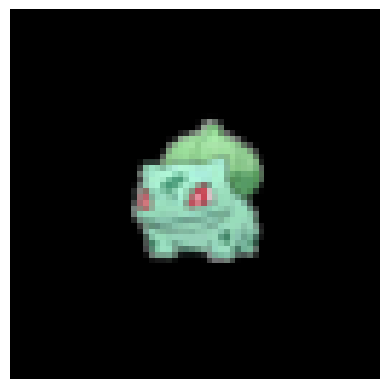

In [ ]:
import matplotlib.pyplot as plt
img_np = img.permute(1, 2, 0).numpy()

plt.imshow(img_np)
plt.axis("off")
plt.show()

Generamos el DataLoader y vemos una de sus imágenes

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(pokemon_dataset, batch_size=64, shuffle=True)

Solo para el caso de una sola etiqueta

Shape del batch de imágenes: torch.Size([64, 3, 64, 64])


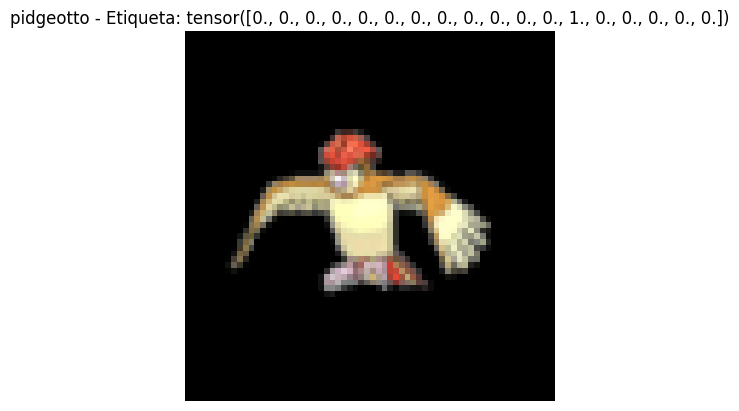

In [ ]:
import matplotlib.pyplot as plt

train_features, train_labels, train_names = next(iter(train_dataloader))

print(f"Shape del batch de imágenes: {train_features.shape}")

img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
name = train_names[0]

plt.imshow(img)
plt.axis("off")
plt.title(f"{name} - Etiqueta: {label}")
plt.show()

# print(f"Label: {label}")

# Creación modelo cVAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

n_G = 96  # número base de canales

class DEC_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, padding=1, alpha=0.2):
        super(DEC_block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(alpha, inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class AUG_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2, padding=1):
        super(AUG_block, self).__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, strides, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class Variational_Encoder(nn.Module):
    def __init__(self, latent_dims, label_dim):
        super(Variational_Encoder, self).__init__()
        self.label_dim = label_dim
        self.conv_seq = nn.Sequential(
            DEC_block(n_G, in_channels=3 + label_dim),  # canales de entrada aumentados
            DEC_block(n_G * 2, n_G),
            DEC_block(n_G * 4, n_G * 2),
            DEC_block(n_G * 8, n_G * 4),
            DEC_block(n_G * 8, n_G * 8),
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten()
        )
        self.fc = nn.Linear(latent_dims + label_dim, n_G * 8 * 1 * 1)
        self.fc_mu = nn.Linear(n_G * 8, latent_dims)
        self.fc_logvar = nn.Linear(n_G * 8, latent_dims)

    def forward(self, x, y):
        y_img = y.unsqueeze(2).unsqueeze(3).expand(-1, -1, x.shape[2], x.shape[3])
        x_cond = torch.cat([x, y_img], dim=1)
        z = self.conv_seq(x_cond)
        mu = self.fc_mu(z)
        log_var = self.fc_logvar(z)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        latent = mu + eps * std
        return latent, mu, log_var

class Decoder(nn.Module):
    def __init__(self, latent_dims, label_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dims + label_dim, n_G * 8 * 1 * 1)
        self.seq = nn.Sequential(
            AUG_block(n_G * 8, n_G * 8),      # 1 → 2
            AUG_block(n_G * 4, n_G * 8),      # 2 → 4
            AUG_block(n_G * 2, n_G * 4),      # 4 → 8
            AUG_block(n_G, n_G * 2),          # 8 → 16
            AUG_block(n_G // 2, n_G),         # 16 → 32
            nn.ConvTranspose2d(n_G // 2, 3, kernel_size=4, stride=2, padding=1),  # 32 → 64
            nn.Sigmoid()
        )

    def forward(self, z, y):
        z_cond = torch.cat([z, y], dim=1)
        z = self.fc(z_cond)
        z = z.view(-1, n_G * 8, 1, 1)
        return self.seq(z)

class ConditionalVAE(nn.Module):
    def __init__(self, latent_dims, label_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Variational_Encoder(latent_dims, label_dim)
        self.decoder = Decoder(latent_dims, label_dim)

    def forward(self, x, y):
        z, mu, log_var = self.encoder(x, y)
        x_hat = self.decoder(z, y)
        return x_hat, mu, log_var

def vae_loss(x, x_hat, mu, log_var, beta=2.0):
    recon_loss = F.binary_cross_entropy(x_hat, x, reduction='sum')
    kl = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + beta * kl

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
label_dim = len(type_binarizer.classes_)
cvae = ConditionalVAE(latent_dims=32, label_dim=label_dim).to(device)

def train(model, data_loader, epochs=20,learning_rate=1e-4):
    model.train()
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(epochs):
        total_loss = 0.0
        total_samples = 0
        for x, y, _ in data_loader:
            x, y = x.to(device), y.to(device)
            opt.zero_grad()
            x_hat, mu, log_var = model(x, y)
            loss = vae_loss(x, x_hat, mu, log_var)
            loss.backward()
            opt.step()
            total_loss += loss.item()
            total_samples += x.size(0)
        avg_loss = total_loss / total_samples
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Entrenamiento
train(cvae, train_dataloader, epochs=200)

Epoch 1, Loss: 13475.4244
Epoch 2, Loss: 8097.5159
Epoch 3, Loss: 7394.0121
Epoch 4, Loss: 6910.5886
Epoch 5, Loss: 6525.0781
Epoch 6, Loss: 6184.1977
Epoch 7, Loss: 5874.2649
Epoch 8, Loss: 5597.9895
Epoch 9, Loss: 5333.8316
Epoch 10, Loss: 5084.0367
Epoch 11, Loss: 4842.5611


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


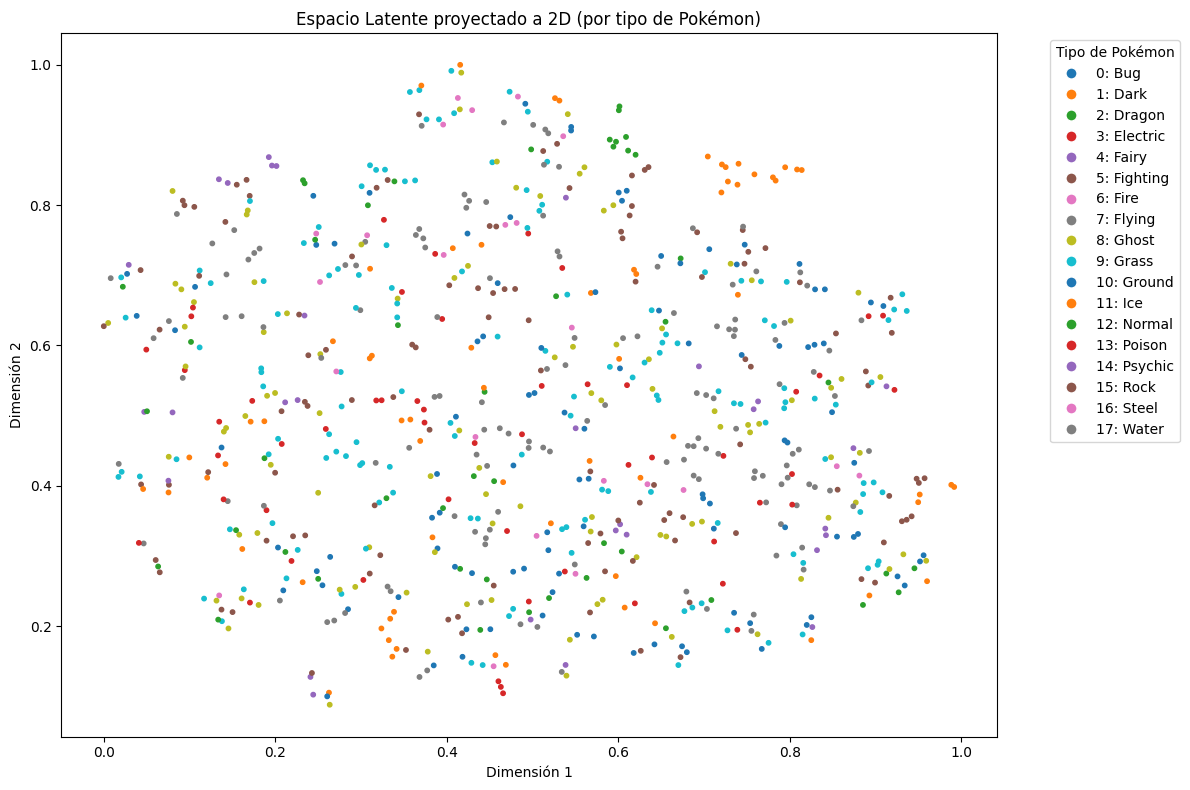

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch

# --- Paso 0: Obtener todas las etiquetas en formato string desde el dataloader ---
all_labels = []

for _, labels, _ in train_dataloader:
    # labels es one-hot [batch_size, num_classes], convertir a índices
    indices = torch.argmax(labels, dim=1)
    # convertir índices a nombres de clases
    labels_str = [type_binarizer.classes_[i] for i in indices]
    all_labels.extend(labels_str)

# Entrenamos el LabelEncoder con las etiquetas string
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# --- Paso 1: Obtener vectores latentes y etiquetas para una muestra del dataset ---
z_list = []
label_list = []

for i, (x, labels, _) in enumerate(train_dataloader):
    if i >= 16:  # tomar solo una muestra pequeña para visualización (~1024 imágenes)
        break
    x = x.to(device)

    # Convertir labels one-hot a índices
    indices = torch.argmax(labels, dim=1)
    # Convertir índices a strings
    labels_str = [type_binarizer.classes_[i] for i in indices]
    label_list.extend(labels_str)

    # Obtener vectores latentes (mu) sin muestreo para t-SNE (puedes usar mu o z)
    with torch.no_grad():
        _, mu, _ = cvae.encoder(x, F.one_hot(indices, num_classes=len(type_binarizer.classes_)).float().to(device))
    z_list.append(mu.cpu())

z_all = torch.cat(z_list, dim=0)

# --- Paso 2: Convertir etiquetas string a números con LabelEncoder ---
numeric_labels = label_encoder.transform(label_list)

# --- Paso 3: t-SNE para reducción a 2D ---
if z_all.shape[1] == 2:
    z_2D = z_all.numpy()
else:
    tsne = TSNE(n_components=2, perplexity=10, learning_rate=50, n_iter=2000, random_state=42)
    z_2D = tsne.fit_transform(z_all.numpy())

# --- Paso 4: Normalización (opcional) ---
z_2D = (z_2D - z_2D.min()) / (z_2D.max() - z_2D.min())

# --- Paso 5: Graficar ---
plt.figure(figsize=(12, 8))
scatter = plt.scatter(z_2D[:, 0], z_2D[:, 1], c=numeric_labels, cmap="tab10", s=10)
plt.title("Espacio Latente proyectado a 2D (por tipo de Pokémon)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=f'{i}: {label}',
           markerfacecolor=plt.cm.tab10(i % 10), markersize=8)
    for i, label in enumerate(label_encoder.classes_)
]
plt.legend(handles=legend_elements, title="Tipo de Pokémon", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [ ]:
import torch
import random

def generar_pokemons_tipo(cvae_model, tipo, n=5, device='cpu'):
    cvae_model.eval()
    y = type_binarizer.transform([tipo])[0]
    y_tensor = torch.tensor(y, dtype=torch.float32).to(device).unsqueeze(0)

    imagenes_generadas = []
    with torch.no_grad():
        for _ in range(n):
            z = torch.randn(1, cvae_model.encoder.fc_mu.out_features).to(device)
            img_gen = cvae_model.decoder(z, y_tensor)
            imagenes_generadas.append(img_gen.squeeze(0).cpu())

    return imagenes_generadas


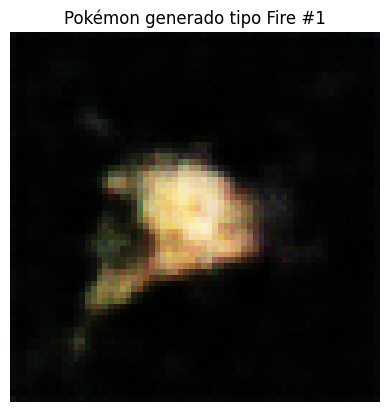

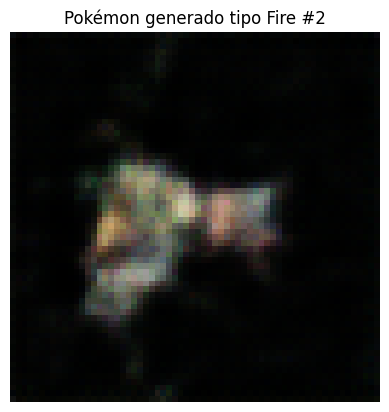

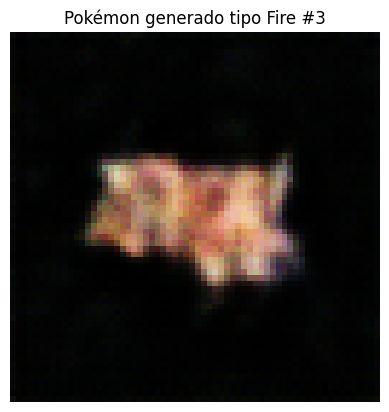

In [ ]:
tipo_deseado = "Fire"
imagenes_generadas = generar_pokemons_tipo(cvae, tipo=tipo_deseado, n=3, device=device)

import matplotlib.pyplot as plt

for i, img_tensor in enumerate(imagenes_generadas):
    img_np = img_tensor.permute(2, 1, 0).numpy()
    plt.figure()
    plt.imshow(img_np)
    plt.title(f"Pokémon generado tipo {tipo_deseado} #{i+1}")
    plt.axis('off')
    plt.show()


***Devolución***

Se identificaron los siguientes aspectos en clase a tener en cuenta para mejorar el desarrollo del proyecto. En primer lugar, es necesario revisar el tamaño de las imágenes utilizadas y realizar un resize uniforme para evitar problemas al momento de la carga con el DataLoader. Además, se debe prestar atención a los nombres de los archivos: es importante que el sistema no los ignore ni los reemplace automáticamente, ya que pueden contener información útil para la clasificación.

Por otro lado, se propone entrenar un modelo VAE con el objetivo de observar cómo agrupa las imágenes y qué criterios visuales prioriza, en particular la forma en que maneja los colores. Esto permitirá evaluar si el modelo es capaz de extraer patrones.

En cuanto a los tipos de Pokémon, es importante definir una estrategia clara. Muchos de ellos poseen dos tipos (por ejemplo, Zapdos es tanto volador como eléctrico), por lo que se recomienda analizar si es necesario utilizar ambos o si conviene trabajar solo con uno. Se sugiere generar ejemplos para cada tipo y evaluar los resultados. Una opción es duplicar las imágenes: cada una asociada a un tipo distinto, lo cual facilitaría un análisis más específico por categoría.

A su vez, se plantea la posibilidad de realizar un análisis visual sobre la clasificación por tipo. Esto podría derivar en experimentos adicionales, como la creación de un mezclador de características o incluso un generador de nuevos Pokémon, combinando propiedades visuales de distintos tipos.

Finalmente, se sugiere organizar adecuadamente el repositorio del proyecto. Todas las imágenes (preprocesadas) deben ubicarse en una carpeta denominada data, y el cuaderno de trabajo (notebook) debe incluir las etapas necesarias para generar el conjunto de datos desde cero.

---



---



#**Segundo Test**


---



---



# Carga de Dataset y DataLoader Pokemon

Importaciones iniciales

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
import kagglehub

Se descarga el Dataset desde la pagina de Kaggle

In [ ]:
path = kagglehub.dataset_download("vishalsubbiah/pokemon-images-and-types")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pokemon-images-and-types


En caso de necesitar tomar el DataSet desde Drive, se monta la conexion a Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Definimos los path donde se encuentran las imágenes y las etiquetas

In [ ]:
#Path drive
# dataset_path = "/content/drive/My Drive/RedesNeuronales"

#Path Kaggle
csv_path = path + "/pokemon.csv"
img_path = path + "/images"

Definimos los métodos del DataSet

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

class PokemonDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+ ".png")
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 1] # se decide usar la etiqueta uno del pokemon al ser la mas representativa (1 tipo)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## cVAE Dataset

In [ ]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import torch

class PokemonDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.img_labels['type_1_encoded'] = self.label_encoder.fit_transform(self.img_labels['type1'])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = self.img_labels.iloc[idx]['name']
        img_path = os.path.join(self.img_dir, img_name + ".png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.img_labels.iloc[idx]['type_1_encoded']
        return image, label

Realizamos la tranformación de las imagenes para que todas tengan el tamaño de 120x120

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((120, 120)),
])

Y cargamos el DataSet

In [ ]:
pokemon_dataset = PokemonDataset(csv_file=csv_path, img_dir=img_path, transform=transform)

Hacemos pruebas para ver que se haya cargado correctamente

In [ ]:
print("Cantidad total de datos:", len(pokemon_dataset))

Cantidad total de datos: 809


Pruebas solo para el caso de una sola etiqueta

In [ ]:
img, label, name = pokemon_dataset[0]
print("Forma de la imagen:", img.shape)
print("Etiquetas:", label)
print("Nombre:", name)

Forma de la imagen: torch.Size([3, 120, 120])
Etiquetas: Grass
Nombre: bulbasaur


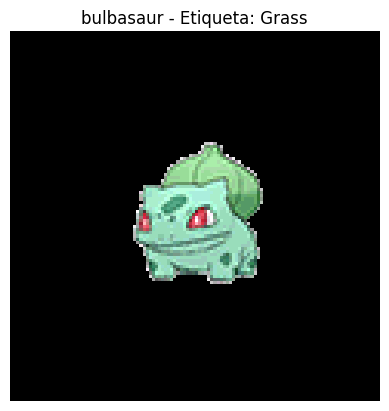

In [ ]:
import matplotlib.pyplot as plt
img_np = img.permute(1, 2, 0).numpy()

plt.imshow(img_np)
plt.title(name + " - " + "Etiqueta: " + label)
plt.axis("off")
plt.show()

Generamos el DataLoader y vemos una de sus imágenes

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(pokemon_dataset, batch_size=64, shuffle=True)

Solo para el caso de una sola etiqueta

Shape del batch de imágenes: torch.Size([64, 3, 120, 120])


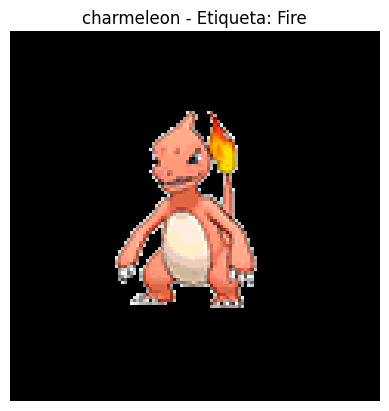

In [ ]:
import matplotlib.pyplot as plt

train_features, train_labels, train_names = next(iter(train_dataloader))

print(f"Shape del batch de imágenes: {train_features.shape}")

img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
name = train_names[0]

plt.imshow(img)
plt.axis("off")
plt.title(f"{name} - Etiqueta: {label}")
plt.show()

# print(f"Label: {label}")

# Creación modelo VAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Variational_Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Variational_Encoder, self).__init__()
        self.flattened_size = 3 * 120 * 120  # por las imágenes 120x120 RGB
        self.linear1 = nn.Linear(self.flattened_size, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, latent_dims)  # media
        self.linear4 = nn.Linear(512, latent_dims)  # log_var

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        z = F.relu(self.linear2(x))
        media = self.linear3(z)
        log_var = self.linear4(z)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        latente = eps * std + media
        return latente, media, log_var


In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.linear3 = nn.Linear(1024, 3 * 120 * 120)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z.view(-1, 3, 120, 120)  # reconstruimos imagen RGB 120x120

In [ ]:
class Variational_Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Variational_Autoencoder, self).__init__()
        self.encoder = Variational_Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z, media, log_var = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, media, log_var

In [ ]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, features, labels):
        batch_size = features.size(0)
        centers_batch = self.centers[labels]
        loss = (features - centers_batch).pow(2).sum() / 2.0 / batch_size
        return loss

In [ ]:
def vae_loss_con_center_loss(x, x_hat, mu, log_var, z, labels, center_loss_fn, alpha=1.0):
    # 1. Pérdida de reconstrucción
    reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')

    # 2. Pérdida KL Divergence
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # 3. Center loss (agrupa por tipo)
    center_loss = center_loss_fn(z, labels)

    total_loss = reconstruction_loss + kl_loss + alpha * center_loss
    return total_loss, reconstruction_loss, kl_loss, center_loss


In [ ]:
from collections import defaultdict
import random

class BalancedPokemonDataset(Dataset):
    def __init__(self, base_dataset, max_per_type=100):
        self.samples = []
        counter = defaultdict(int)

        for img, label in base_dataset:
            if counter[label] < max_per_type:
                self.samples.append((img, label))
                counter[label] += 1

        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [ ]:
balanced_dataset = BalancedPokemonDataset(pokemon_dataset, max_per_type=80)
balanced_loader = DataLoader(balanced_dataset, batch_size=64, shuffle=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def train(autoencoder, dataloader, epochs=20, save_path='best_vae.pth'):
    label_encoder = LabelEncoder()
    all_labels = [label for _, label in dataloader.dataset]
    label_encoder.fit(all_labels)
    num_classes = len(label_encoder.classes_)

    center_loss_fn = CenterLoss(num_classes=num_classes, feat_dim=autoencoder.encoder.linear3.out_features).to(device)
    opt = Adam(list(autoencoder.parameters()) + list(center_loss_fn.parameters()), lr=1e-3)

    best_loss = float('inf')

    for epoch in range(epochs):
        autoencoder.train()
        total_loss = 0.0
        total_pixels = 0

        for x, label in dataloader:
            x = x.to(device)
            encoded_labels = torch.tensor(label_encoder.transform(label)).to(device)

            opt.zero_grad()
            z, mu, log_var = autoencoder.encoder(x)
            x_hat = autoencoder.decoder(z)

            loss, recon_loss, kl_loss, c_loss = vae_loss_con_center_loss(
                x, x_hat, mu, log_var, z, encoded_labels, center_loss_fn
            )

            loss.backward()
            opt.step()

            total_loss += loss.item()
            total_pixels += x.numel()

        avg_loss = total_loss / total_pixels
        print(f"[Epoch {epoch+1}/{epochs}] Total: {avg_loss:.6f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(autoencoder.state_dict(), save_path)
            print("✅ Mejor modelo actualizado.")

    return label_encoder  # lo necesitamos para los siguientes pasos


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

def visualizar_latentes(vae, dataloader, label_encoder, metodo="tsne", cantidad_max=1000):
    vae.eval()
    z_list = []
    label_list = []

    with torch.no_grad():
        total = 0
        for x, label in dataloader:
            x = x.to(device)
            encoded_labels = label_encoder.transform(label)
            z, _, _ = vae.encoder(x)

            z_list.append(z.cpu())
            label_list.extend(encoded_labels)

            total += len(x)
            if total >= cantidad_max:
                break

    z_all = torch.cat(z_list, dim=0).numpy()
    label_array = np.array(label_list)

    # Reducción de dimensión
    if metodo == "tsne":
        z_2D = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000).fit_transform(z_all)
    elif metodo == "pca":
        z_2D = PCA(n_components=2).fit_transform(z_all)
    else:
        raise ValueError("Método de reducción no válido: tsne o pca")

    # Normalización opcional
    z_2D = (z_2D - z_2D.min(0)) / (z_2D.max(0) - z_2D.min(0))

    # Gráfico
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(z_2D[:, 0], z_2D[:, 1], c=label_array, cmap="tab20", s=12)

    # Leyenda
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               label=f'{i}: {label}',
               markerfacecolor=plt.cm.tab20(i % 20), markersize=8)
        for i, label in enumerate(label_encoder.classes_)
    ]
    plt.legend(handles=legend_elements, title="Tipo de Pokémon", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f"Espacio latente con agrupación por tipo ({metodo.upper()})")
    plt.xlabel("Latente 1")
    plt.ylabel("Latente 2")
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


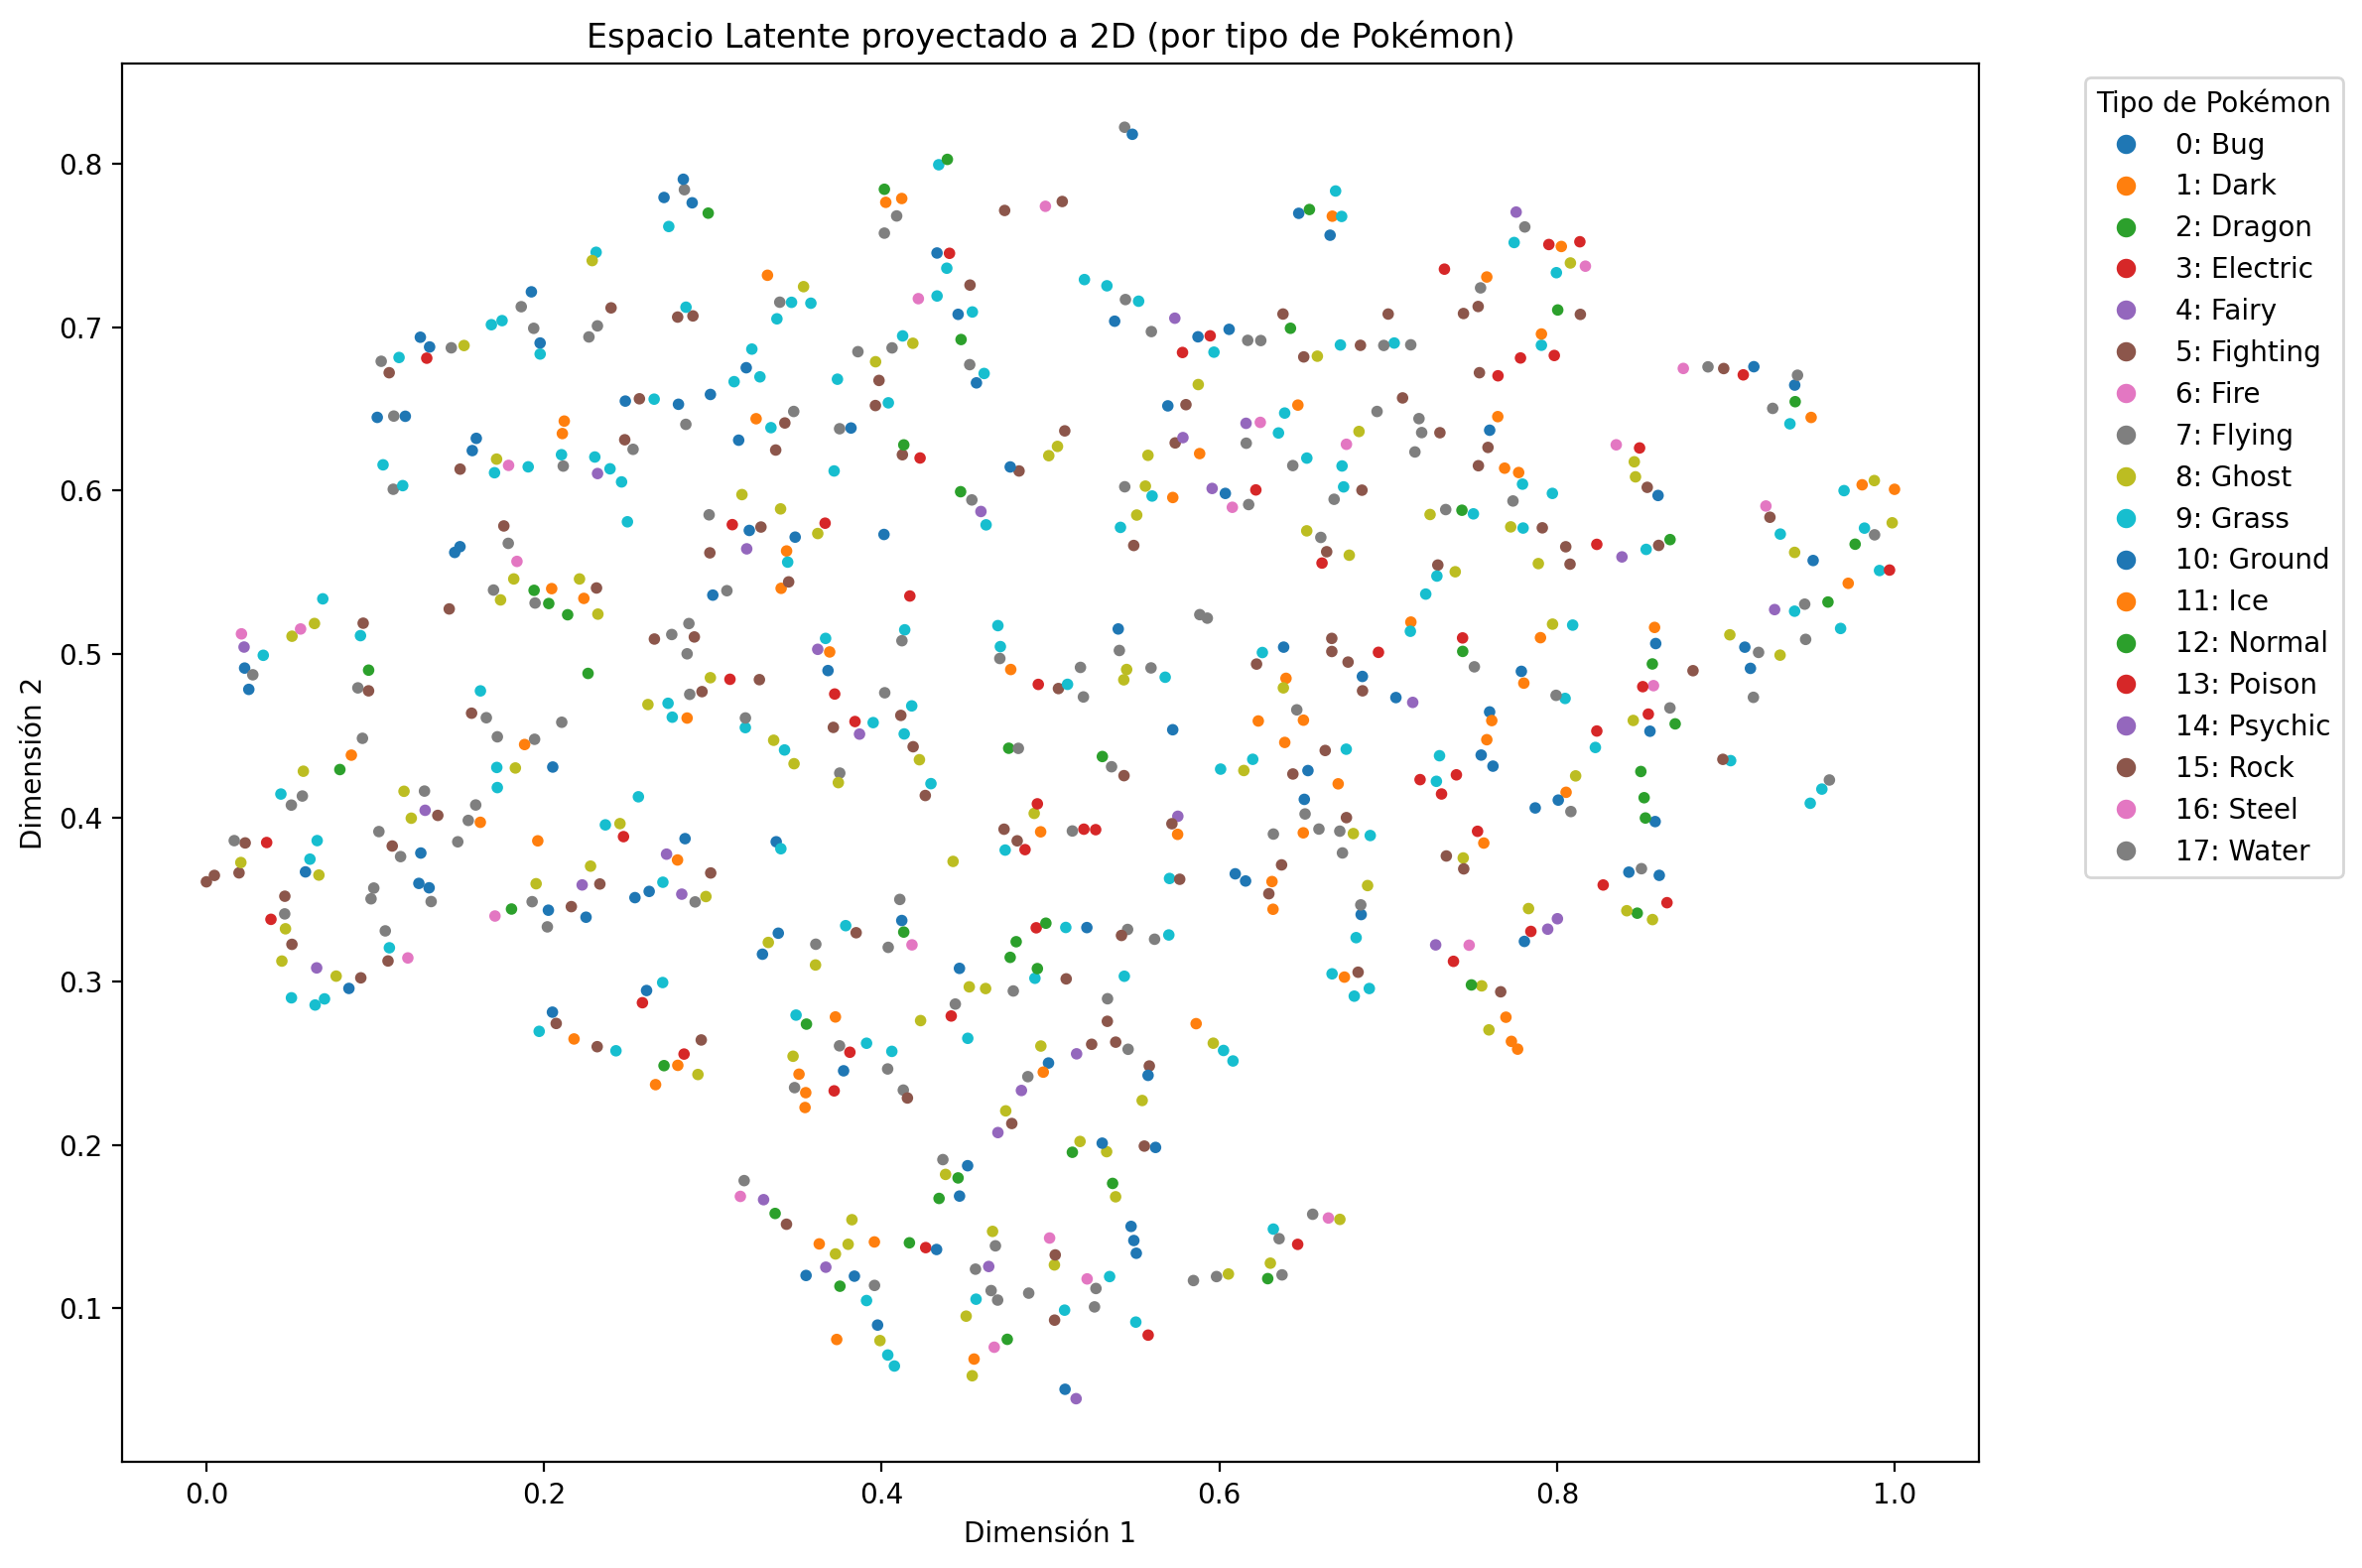

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Paso 1: Obtenemos vectores latentes y etiquetas
z_list = []
label_list = []

for i, (x, label) in enumerate(train_dataloader):
    if i >= 16:  # Hasta ~1024 imágenes
        break
    x = x.to(device)
    z, _, _ = vae.encoder(x)
    z_list.append(z.detach().cpu())
    label_list.extend(label)  # Esto son strings tipo "Water", "Fire", etc.

z_all = torch.cat(z_list, dim=0)

# Paso 2: Convertir etiquetas a números con LabelEncoder
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(label_list)  # Cada tipo tiene un número único

# Paso 3: TSNE para reducción a 2D
if z_all.shape[1] == 2:
    z_2D = z_all.numpy()
else:
    tsne = TSNE(n_components=2, perplexity=10, learning_rate=100, n_iter=3000, random_state=42)
    z_2D = tsne.fit_transform(z_all.numpy())

# Paso 4: Normalización (opcional)
z_2D = (z_2D - z_2D.min()) / (z_2D.max() - z_2D.min())

# Paso 5: Graficar
plt.figure(figsize=(12, 8))
scatter = plt.scatter(z_2D[:, 0], z_2D[:, 1], c=numeric_labels, cmap="tab10", s=10)
plt.title("Espacio Latente proyectado a 2D (por tipo de Pokémon)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")

# Leyenda personalizada sin colorbar
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=f'{i}: {label}',
           markerfacecolor=plt.cm.tab10(i % 10), markersize=8)
    for i, label in enumerate(label_encoder.classes_)
]
plt.legend(handles=legend_elements, title="Tipo de Pokémon", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# label_encoder = train(vae, train_dataloader, epochs=200)
# visualizar_latentes(vae, train_dataloader, label_encoder, metodo="tsne")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # vae = Variational_Autoencoder(latent_dims=10).to(device)
# # label_encoder = train(vae, balanced_loader, epochs=30)
vae = Variational_Autoencoder(latent_dims=10).to(device)
label_encoder = train(vae, balanced_loader, epochs=30)

[Epoch 1/30] Total: 0.086812
✅ Mejor modelo actualizado.
[Epoch 2/30] Total: 0.039836
✅ Mejor modelo actualizado.
[Epoch 3/30] Total: 0.034342
✅ Mejor modelo actualizado.
[Epoch 4/30] Total: 0.032418
✅ Mejor modelo actualizado.
[Epoch 5/30] Total: 0.031423
✅ Mejor modelo actualizado.
[Epoch 6/30] Total: 0.030466
✅ Mejor modelo actualizado.
[Epoch 7/30] Total: 0.029661
✅ Mejor modelo actualizado.
[Epoch 8/30] Total: 0.029098
✅ Mejor modelo actualizado.
[Epoch 9/30] Total: 0.028521
✅ Mejor modelo actualizado.
[Epoch 10/30] Total: 0.027698
✅ Mejor modelo actualizado.
[Epoch 11/30] Total: 0.027081
✅ Mejor modelo actualizado.
[Epoch 12/30] Total: 0.026697
✅ Mejor modelo actualizado.
[Epoch 13/30] Total: 0.026252
✅ Mejor modelo actualizado.
[Epoch 14/30] Total: 0.025905
✅ Mejor modelo actualizado.
[Epoch 15/30] Total: 0.025779
✅ Mejor modelo actualizado.
[Epoch 16/30] Total: 0.025306
✅ Mejor modelo actualizado.
[Epoch 17/30] Total: 0.024814
✅ Mejor modelo actualizado.
[Epoch 18/30] Total: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


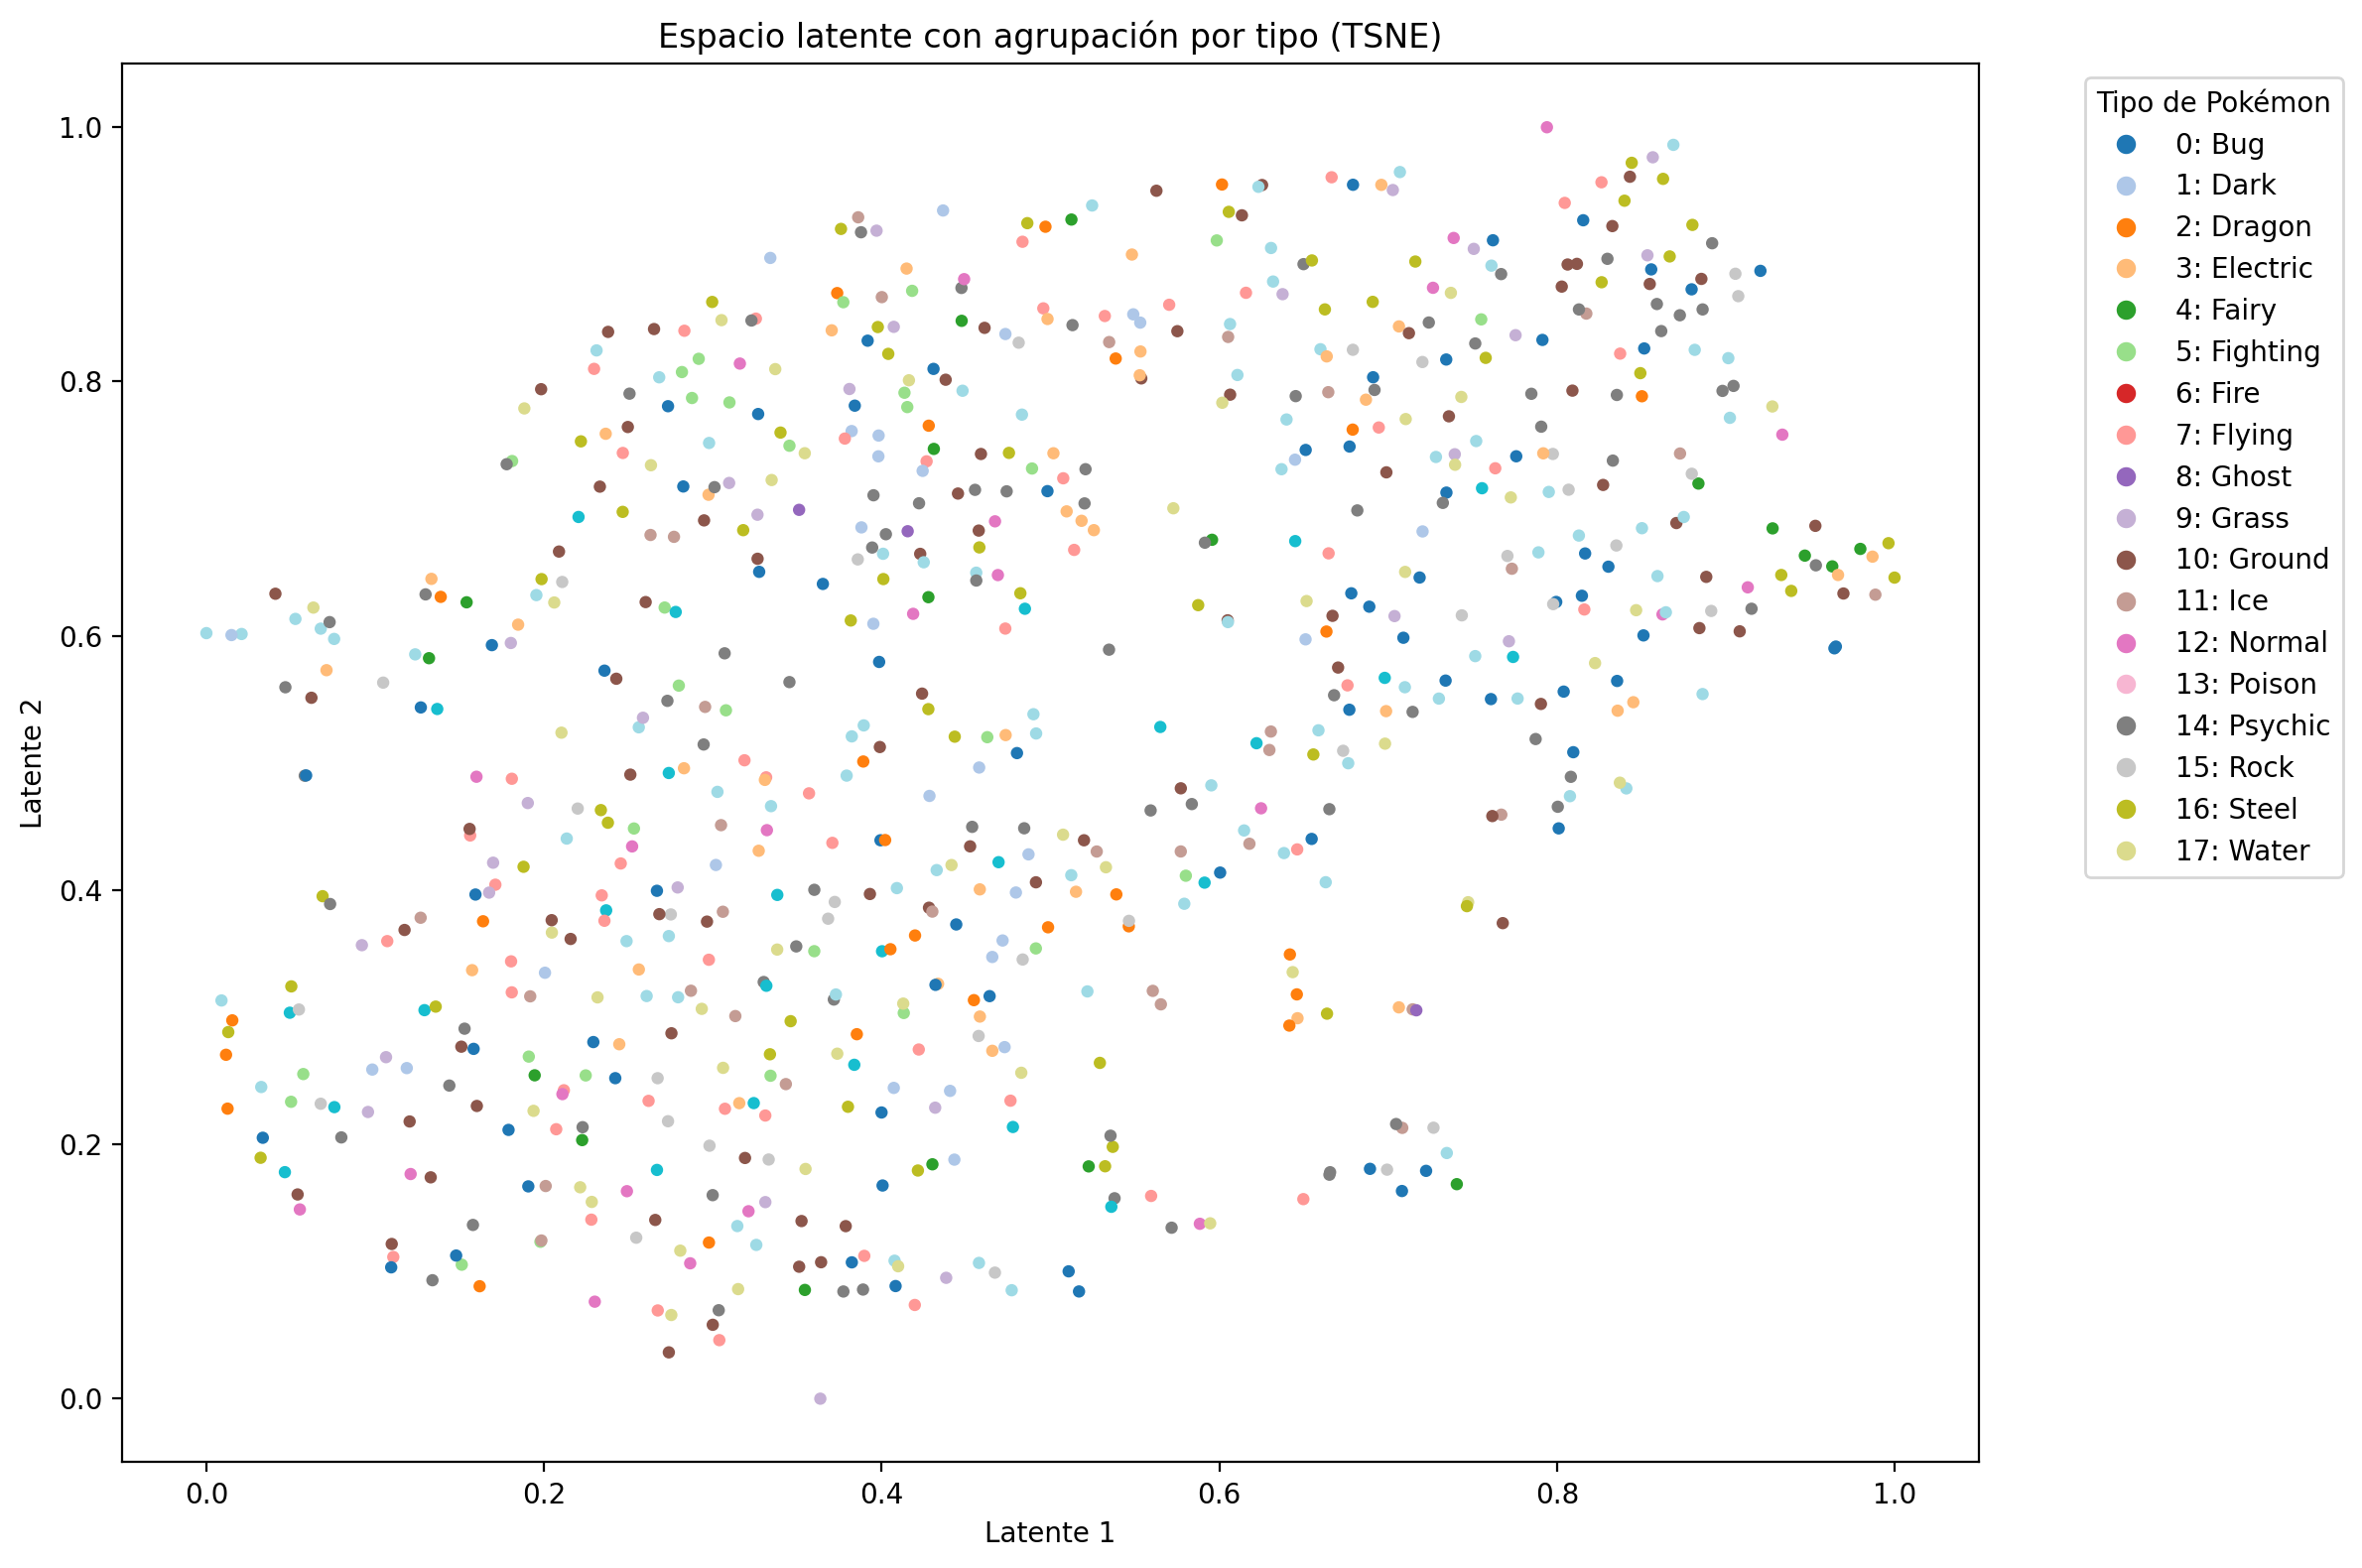

In [ ]:
visualizar_latentes(vae, balanced_loader, label_encoder, metodo="tsne")

In [ ]:
def generar_pokemones_por_tipo(vae, dataset, tipo_deseado, cantidad=5):
    vae.eval()
    embeddings = []

    # Paso 1: filtrar imágenes por tipo deseado
    for i in range(len(dataset)):
        img, label = dataset[i]
        if label.lower() == tipo_deseado.lower():
            img = img.unsqueeze(0).to(device)
            with torch.no_grad():
                z, _, _ = vae.encoder(img)
            embeddings.append(z.cpu())

    if len(embeddings) == 0:
        print(f"No se encontraron Pokémon del tipo {tipo_deseado}")
        return

    embeddings = torch.cat(embeddings, dim=0)

    print(f"Generando {cantidad} Pokémon nuevos a partir de {len(embeddings)} ejemplos del tipo {tipo_deseado}.")

    nuevos_pokemones = []
    for _ in range(cantidad):
        # Elegir 2 embeddings al azar y hacer interpolación lineal
        idx_a, idx_b = torch.randint(0, len(embeddings), (2,))
        a, b = embeddings[idx_a], embeddings[idx_b]
        alpha = torch.rand(1).item()
        z_nuevo = alpha * a + (1 - alpha) * b

        # Decodificar
        with torch.no_grad():
            img_nueva = vae.decoder(z_nuevo.to(device)).cpu().squeeze().permute(1, 2, 0).numpy()
            nuevos_pokemones.append(img_nueva)

    # Mostrar imágenes generadas
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, cantidad, figsize=(15, 3))
    for i, img in enumerate(nuevos_pokemones):
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.suptitle(f"Nuevos Pokémon tipo {tipo_deseado}")
    plt.show()

Generando 5 Pokémon nuevos a partir de 72 ejemplos del tipo bug.


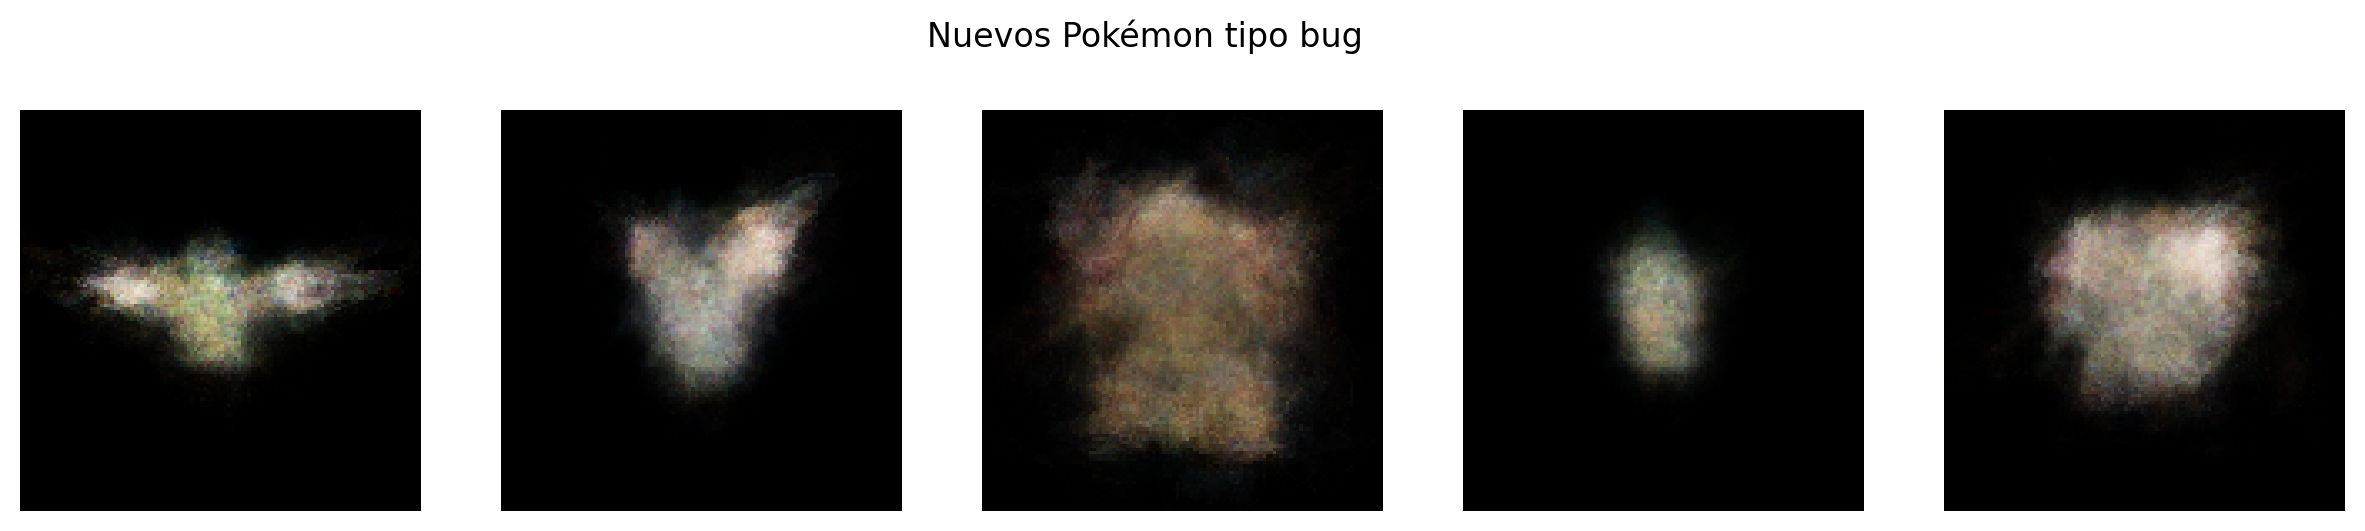

In [ ]:
generar_pokemones_por_tipo(vae, pokemon_dataset, tipo_deseado="bug", cantidad=5)

# CVAE


In [ ]:
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import torch

class PokemonDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.img_labels['type_1_encoded'] = self.label_encoder.fit_transform(self.img_labels['type1'])

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_name = self.img_labels.iloc[idx]['name']
        img_path = os.path.join(self.img_dir, img_name + ".png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.img_labels.iloc[idx]['type_1_encoded']
        return image, label

In [ ]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#establece la semilla para que los generadores aleatorios sean consistentes entre corridas
torch.manual_seed(0)

#establece cuántas dimensiones tendrá el espacio latente
codings_size = 30

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dims, num_classes):
        super(Encoder, self).__init__()

        # Capas convolucionales
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)   # 120x120 → 60x60
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # 60x60 → 30x30
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # 30x30 → 15x15
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)# 15x15 → 8x8

        self.flatten = nn.Flatten()

        # Cálculo automático del tamaño plano
        with torch.no_grad():
            dummy_x = torch.zeros(1, 3, 120, 120)  # imagen dummy
            x = F.relu(self.conv1(dummy_x))
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))
            x = F.relu(self.conv4(x))
            flat_dim = x.view(1, -1).shape[1] + num_classes  # suma el tipo one-hot

        # Capas lineales
        self.fc1 = nn.Linear(flat_dim, 512)
        self.fc2_mu = nn.Linear(512, latent_dims)
        self.fc2_logvar = nn.Linear(512, latent_dims)

    def forward(self, x, labels_onehot):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.flatten(x)
        x = torch.cat([x, labels_onehot], dim=1)
        h = F.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, latent_dims, num_classes):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dims + num_classes, 256 * 8 * 8)

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # 8x8 -> 16x16
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # 16x16 -> 32x32
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)    # 32x32 -> 64x64
        self.deconv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)     # 64x64 -> 128x128
        self.crop = nn.Identity()  # te muestro luego cómo recortar a 120x120 si sobra

    def forward(self, z, labels_onehot):
        x = torch.cat([z, labels_onehot], dim=1)
        x = F.relu(self.fc(x))
        x = x.view(-1, 256, 8, 8)
        x = F.relu(self.deconv1(x))  # (B, 128, 16, 16)
        x = F.relu(self.deconv2(x))  # (B, 64, 32, 32)
        x = F.relu(self.deconv3(x))  # (B, 32, 64, 64)
        x = torch.sigmoid(self.deconv4(x))  # (B, 3, 128, 128)

        # Recortamos a 120x120 si querés exacto:
        x = x[:, :, 4:124, 4:124]  # (B, 3, 120, 120)
        return x

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dims, num_classes):
        super(ConditionalVAE, self).__init__()
        self.latent_dims = latent_dims        # Guardamos la dimensión latente
        self.num_classes = num_classes        # Guardamos la cantidad de clases (tipos)
        self.encoder = Encoder(latent_dims, num_classes)
        self.decoder = Decoder(latent_dims, num_classes)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels_onehot):
        mu, logvar = self.encoder(x, labels_onehot)       # Encoder condicional
        z = self.reparameterize(mu, logvar)               # Reparametrización
        x_recon = self.decoder(z, labels_onehot)          # Decoder condicional
        return x_recon, mu, logvar

In [ ]:
def cvae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')  # o F.binary_cross_entropy para datos [0,1]
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [ ]:
def train(cvae, data, label_encoder, onehot_encoder, epochs=20):
    cvae.train()
    opt = torch.optim.Adam(cvae.parameters())

    for epoch in range(epochs):
        total_loss = 0.0
        total_pixels = 0

        for x, y in data:
            x = x.to(device)  # (B, 3, 120, 120)

            # Paso 1: Codificar etiquetas a one-hot
            y_encoded = label_encoder.transform(y)  # int labels
            y_onehot = onehot_encoder.transform(y_encoded.reshape(-1, 1))
            y_onehot = torch.tensor(y_onehot, dtype=torch.float32).to(device)  # (B, num_classes)

            # Paso 2: Forward + pérdida
            opt.zero_grad()
            x_hat, mu, logvar = cvae(x, y_onehot)
            loss = cvae_loss(x_hat, x, mu, logvar)

            # Paso 3: Backprop y optimización
            loss.backward()
            opt.step()

            total_loss += loss.item()
            total_pixels += x.numel()

        print(f"Epoch {epoch+1}, Loss: {(total_loss / total_pixels):.6f}")

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

all_labels = []
for i in range(len(pokemon_dataset)):
    _, label = pokemon_dataset[i]
    all_labels.append(label)

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False)  # <- corregido

y_encoded = label_encoder.fit_transform(all_labels)
y_onehot = onehot_encoder.fit_transform(y_encoded.reshape(-1, 1))

# Inicializar modelo
latent_dims = 20
num_classes = len(label_encoder.classes_)
cvae = ConditionalVAE(latent_dims, num_classes).to(device)

# Entrenar
train(cvae, train_dataloader, label_encoder, onehot_encoder, epochs=20)

Epoch 1, Loss: 0.139242
Epoch 2, Loss: 0.064385
Epoch 3, Loss: 0.058510
Epoch 4, Loss: 0.040212
Epoch 5, Loss: 0.036596
Epoch 6, Loss: 0.034736
Epoch 7, Loss: 0.033644
Epoch 8, Loss: 0.032758
Epoch 9, Loss: 0.032190
Epoch 10, Loss: 0.031642
Epoch 11, Loss: 0.031151
Epoch 12, Loss: 0.030744
Epoch 13, Loss: 0.029746
Epoch 14, Loss: 0.028982
Epoch 15, Loss: 0.028209
Epoch 16, Loss: 0.027379
Epoch 17, Loss: 0.026852
Epoch 18, Loss: 0.026305
Epoch 19, Loss: 0.025686
Epoch 20, Loss: 0.024965


In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space(cvae, dataloader, label_encoder, device, num_batches=100):
    cvae.eval()
    zs = []
    labels = []

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            if i > num_batches:
                break
            x = x.to(device)

            # Convertir etiquetas a one-hot para alimentar encoder
            y_encoded = label_encoder.transform(y)
            y_onehot = torch.zeros(len(y_encoded), len(label_encoder.classes_)).to(device)
            y_onehot.scatter_(1, torch.tensor(y_encoded).unsqueeze(1).to(device), 1)

            mu, _ = cvae.encoder(x, y_onehot)
            zs.append(mu.cpu().numpy())
            labels.extend(y_encoded)

    zs = np.concatenate(zs, axis=0)
    labels = np.array(labels)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(zs[:,0], zs[:,1], c=labels, cmap='tab20', alpha=0.7, s=10)
    plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)))
    plt.title('Espacio latente (mu) de CVAE')
    plt.xlabel('Latent dim 1')
    plt.ylabel('Latent dim 2')
    plt.show()

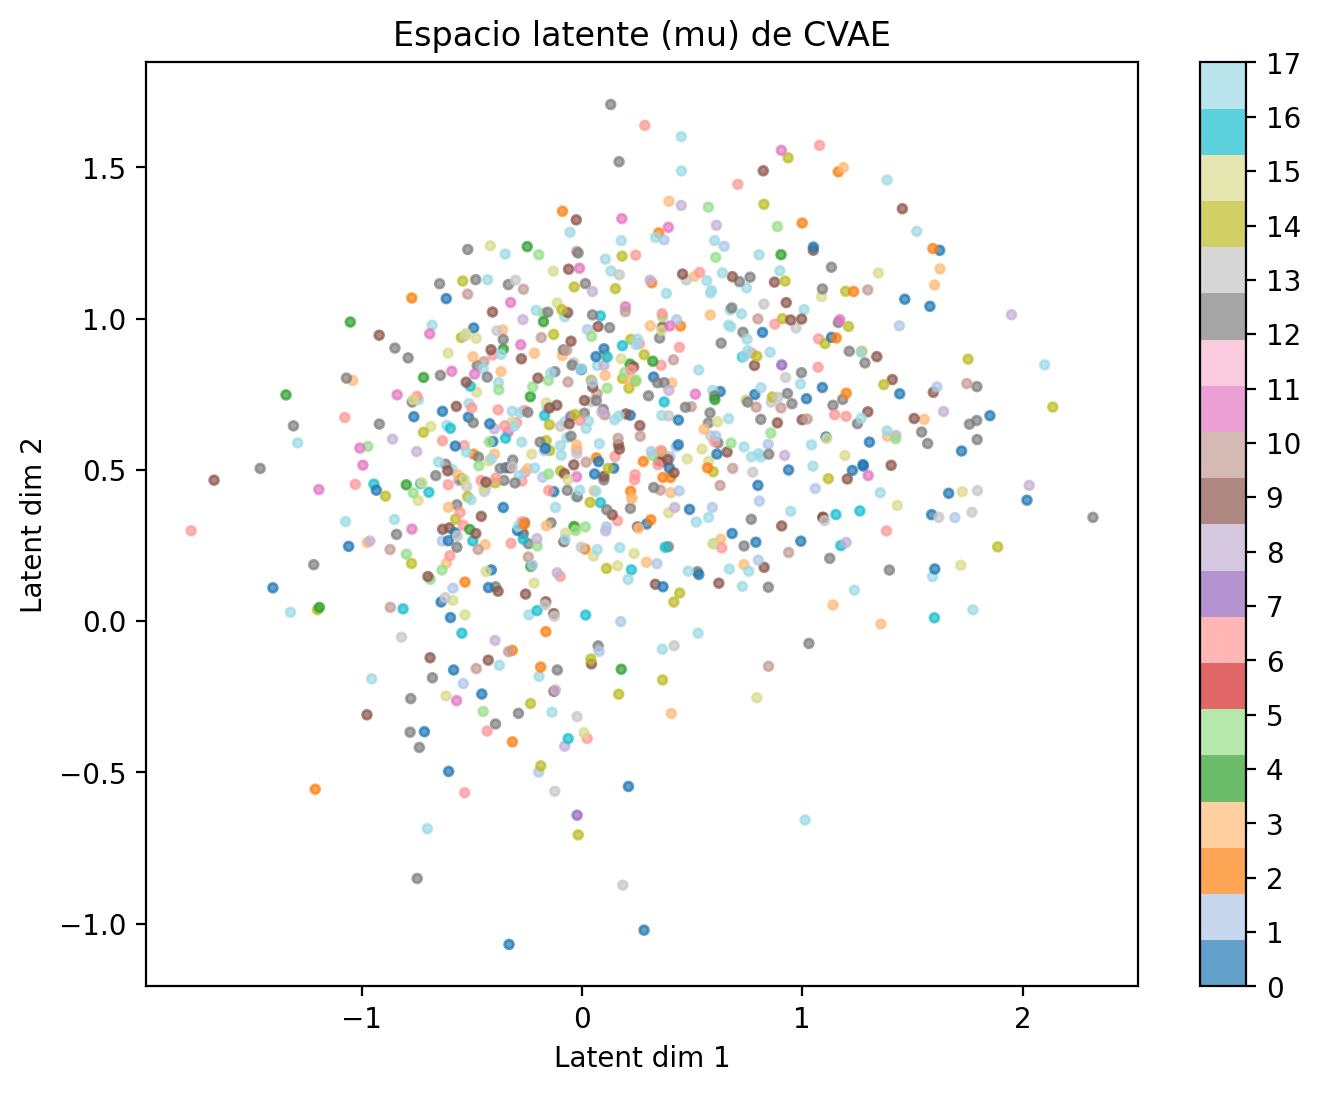

In [ ]:
plot_latent_space(cvae, train_dataloader, label_encoder, device)

In [ ]:
def generate_pokemons(cvae, label_encoder, tipo_nombre, n=5, device='cpu'):
    cvae.eval()
    tipo_idx = label_encoder.transform([tipo_nombre])[0]

    # One-hot para el tipo elegido
    tipo_onehot = torch.zeros((n, len(label_encoder.classes_)), device=device)
    tipo_onehot[:, tipo_idx] = 1

    # Muestreamos z ~ N(0,1)
    z = torch.randn(n, cvae.latent_dims, device=device)

    # Generamos imágenes
    with torch.no_grad():
        imgs = cvae.decoder(z, tipo_onehot)

    imgs = imgs.cpu()

    # Mostrar imágenes
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    for i in range(n):
        ax = axes[i]
        img = imgs[i].permute(1,2,0).numpy()
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{tipo_nombre} #{i+1}")
    plt.show()

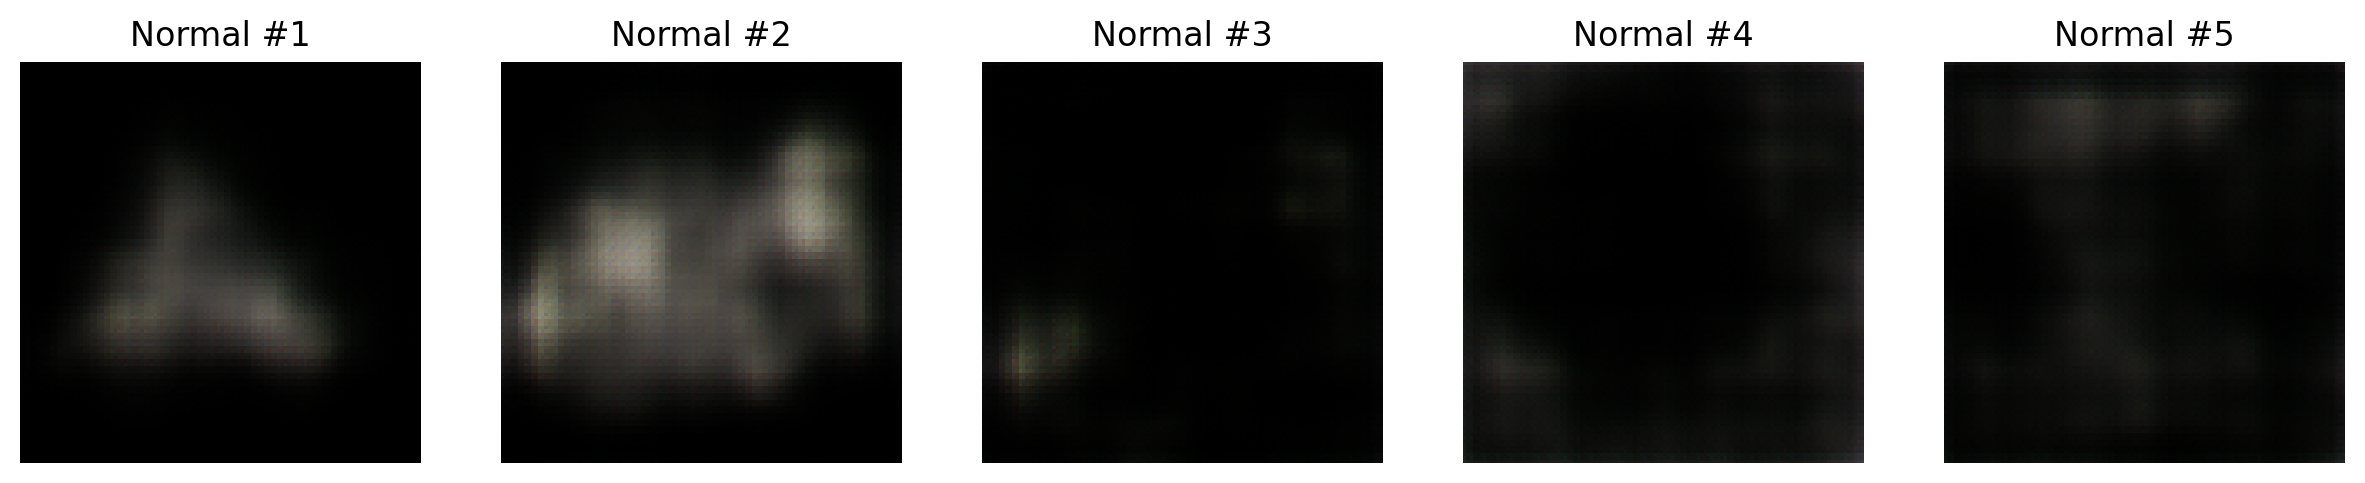

In [ ]:
generate_pokemons(cvae, label_encoder, "Normal", n=5, device=device)

# CVAE 2


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=64, num_classes=18):  # 18 tipos de Pokémon
        super().__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        self.label_embed = nn.Linear(num_classes, 120 * 120)

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # (60, 60)
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # (30, 30)
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # (15, 15)
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 15 * 15 + num_classes, latent_dim)
        self.fc_logvar = nn.Linear(128 * 15 * 15 + num_classes, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim + num_classes, 128 * 15 * 15)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 15, 15)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # (30, 30)
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),   # (60, 60)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),    # (120, 120)
            nn.Sigmoid()
        )

    def encode(self, x, y):
        x_encoded = self.encoder(x)
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        x_cat = torch.cat([x_encoded, y_onehot], dim=1)
        mu = self.fc_mu(x_cat)
        logvar = self.fc_logvar(x_cat)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        z_cat = torch.cat([z, y_onehot], dim=1)
        x = self.decoder_input(z_cat)
        return self.decoder(x)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mu, logvar

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [ ]:
from torch.utils.data import DataLoader

dataloader = DataLoader(pokemon_dataset, batch_size=64, shuffle=True)
model = ConditionalVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(num_epochs):
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        recon_images, mu, logvar = model(images, labels)
        loss = vae_loss(recon_images, images, mu, logvar)
        loss.backward()
        optimizer.step()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Suponiendo que ya tienes un dataloader de validación
latents = []
labels = []

with torch.no_grad():
    for images, lbls in pokemon_dataloader:
        images = images.to(device)
        lbls = lbls.to(device)
        mu, _ = model.encode(images, lbls)
        latents.append(mu.cpu())
        labels.append(lbls.cpu())

latents = torch.cat(latents)
labels = torch.cat(labels)

tsne = TSNE(n_components=2)
tsne_latents = tsne.fit_transform(latents)

plt.figure(figsize=(10, 10))
plt.scatter(tsne_latents[:, 0], tsne_latents[:, 1], c=labels, cmap='tab20')
plt.colorbar()
plt.title("Espacio latente condicionado por tipo")
plt.show()

Epoch 1, Loss: 0.139242
Epoch 2, Loss: 0.064385
Epoch 3, Loss: 0.058510
Epoch 4, Loss: 0.040212
Epoch 5, Loss: 0.036596
Epoch 6, Loss: 0.034736
Epoch 7, Loss: 0.033644
Epoch 8, Loss: 0.032758
Epoch 9, Loss: 0.032190
Epoch 10, Loss: 0.031642
Epoch 11, Loss: 0.031151
Epoch 12, Loss: 0.030744
Epoch 13, Loss: 0.029746
Epoch 14, Loss: 0.028982
Epoch 15, Loss: 0.028209
Epoch 16, Loss: 0.027379
Epoch 17, Loss: 0.026852
Epoch 18, Loss: 0.026305
Epoch 19, Loss: 0.025686
Epoch 20, Loss: 0.024965


In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space(cvae, dataloader, label_encoder, device, num_batches=100):
    cvae.eval()
    zs = []
    labels = []

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            if i > num_batches:
                break
            x = x.to(device)

            # Convertir etiquetas a one-hot para alimentar encoder
            y_encoded = label_encoder.transform(y)
            y_onehot = torch.zeros(len(y_encoded), len(label_encoder.classes_)).to(device)
            y_onehot.scatter_(1, torch.tensor(y_encoded).unsqueeze(1).to(device), 1)

            mu, _ = cvae.encoder(x, y_onehot)
            zs.append(mu.cpu().numpy())
            labels.extend(y_encoded)

    zs = np.concatenate(zs, axis=0)
    labels = np.array(labels)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(zs[:,0], zs[:,1], c=labels, cmap='tab20', alpha=0.7, s=10)
    plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)))
    plt.title('Espacio latente (mu) de CVAE')
    plt.xlabel('Latent dim 1')
    plt.ylabel('Latent dim 2')
    plt.show()

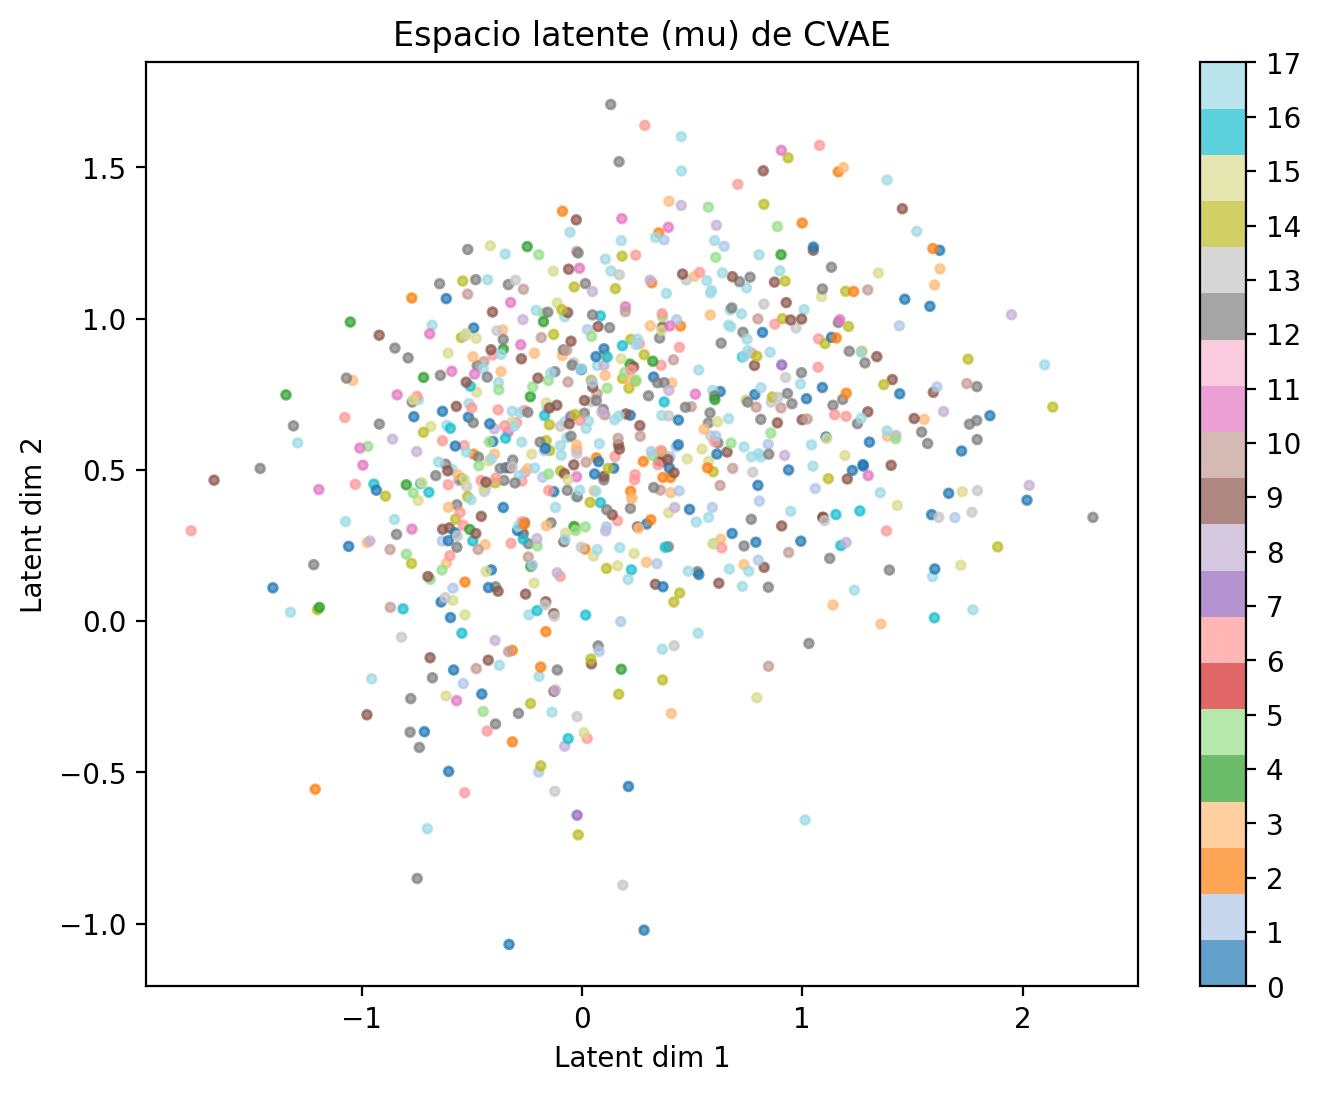

In [ ]:
plot_latent_space(cvae, train_dataloader, label_encoder, device)

In [ ]:
def generate_pokemon(model, type_id, device):
    model.eval()
    with torch.no_grad():
        z = torch.randn(1, model.latent_dim).to(device)
        y = torch.tensor([type_id]).to(device)
        gen_image = model.decode(z, y).squeeze(0).cpu()
        plt.imshow(gen_image.permute(1, 2, 0))
        plt.title(f"Tipo: {type_id}")
        plt.axis('off')
        plt.show()

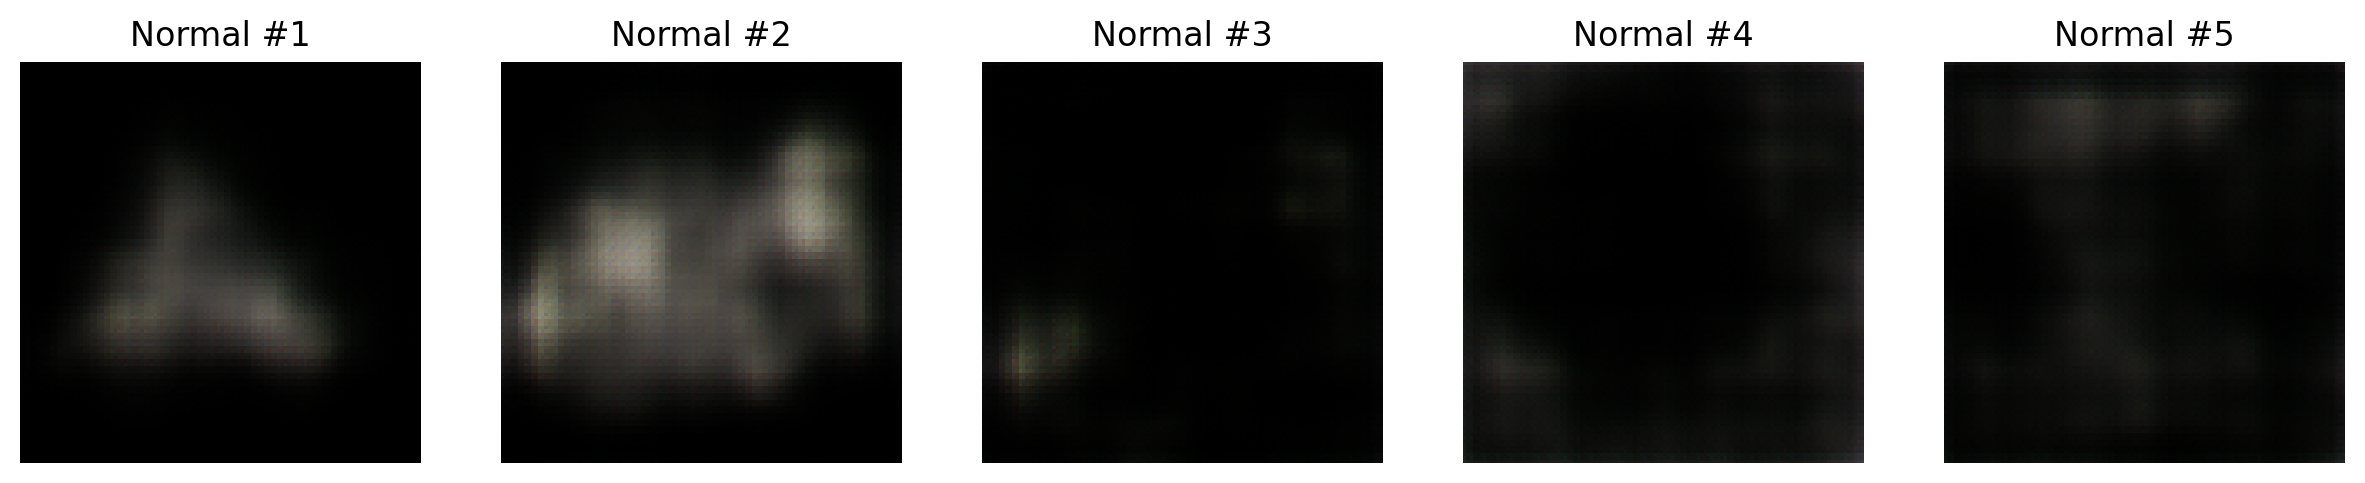

In [ ]:
generate_pokemon(cvae, label_encoder, "Normal", n=5, device=device)

---



---



#**Tercer Test**


---



---




In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
import kagglehub

In [ ]:
path = kagglehub.dataset_download("vishalsubbiah/pokemon-images-and-types")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/pokemon-images-and-types


In [ ]:
#Path drive
# dataset_path = "/content/drive/My Drive/RedesNeuronales"

#Path Kaggle
csv_path = path + "/pokemon.csv"
img_path = path + "/images"

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
from sklearn.preprocessing import LabelEncoder

transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(contrast=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class PokemonDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

        # Codificar el tipo primario con LabelEncoder
        self.label_encoder = LabelEncoder()
        self.encoded_types = self.label_encoder.fit_transform(self.img_labels.iloc[:, 1])  # Segunda columna: tipo 1

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + ".png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = self.encoded_types[idx]
        return image, label


In [ ]:
import torch.nn as nn
import torch
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.enc_conv1 = nn.Conv2d(3, 32, 4, 2, 1)  # (120 -> 60)
        self.enc_bn1 = nn.BatchNorm2d(32)

        self.enc_conv2 = nn.Conv2d(32, 64, 4, 2, 1) # (60 -> 30)
        self.enc_bn2 = nn.BatchNorm2d(64)

        self.enc_conv3 = nn.Conv2d(64, 128, 4, 2, 1) # (30 -> 15)
        self.enc_bn3 = nn.BatchNorm2d(128)

        self.enc_conv4 = nn.Conv2d(128, 256, 4, 2, 1) # (15 -> 7)
        self.enc_bn4 = nn.BatchNorm2d(256)

        # Tamaño después de conv = 256 channels x 7 x 7 = 12544
        self.fc_mu = nn.Linear(256*7*7, latent_dim)
        self.fc_logvar = nn.Linear(256*7*7, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 256*7*7)

        self.dec_conv1 = nn.ConvTranspose2d(256, 128, 4, 2, 1) # (7 -> 14)
        self.dec_bn1 = nn.BatchNorm2d(128)

        self.dec_conv2 = nn.ConvTranspose2d(128, 64, 4, 2, 1) # (14 -> 28)
        self.dec_bn2 = nn.BatchNorm2d(64)

        self.dec_conv3 = nn.ConvTranspose2d(64, 32, 4, 2, 1) # (28 -> 56)
        self.dec_bn3 = nn.BatchNorm2d(32)

        self.dec_conv4 = nn.ConvTranspose2d(32, 3, 4, 2, 1) # (56 -> 112)

        # Vamos a recortar a 120x120 después o ajustar el tamaño input o usar padding.
        # Aquí es un ejemplo, podrías cambiar la arquitectura para llegar justo a 120.

    def encode(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        x = F.relu(self.enc_bn3(self.enc_conv3(x)))
        x = F.relu(self.enc_bn4(self.enc_conv4(x)))
        x = torch.flatten(x, start_dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.fc_dec(z)
        x = x.view(-1, 256, 7, 7)
        x = F.relu(self.dec_bn1(self.dec_conv1(x)))
        x = F.relu(self.dec_bn2(self.dec_conv2(x)))
        x = F.relu(self.dec_bn3(self.dec_conv3(x)))
        x = torch.tanh(self.dec_conv4(x))  # salida en [-1,1]
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar



In [ ]:
def vae_loss(recon_x, x, mu, logvar, beta=4.0):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div

def train_vae(model, dataloader, epochs=900, lr=1e-3, device='cuda'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, _ in dataloader:
            x = x.to(device)
            optimizer.zero_grad()
            x_recon, mu, logvar = model(x)
            loss = vae_loss(x_recon, x, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.2f}")



In [ ]:
from torch.utils.data import DataLoader

dataset = PokemonDataset(csv_path, img_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

vae = ConvVAE(latent_dim=128)
train_vae(vae, dataloader, epochs=1000, device='cuda')

Epoch 1/1000, Loss: 16005054.34
Epoch 2/1000, Loss: 4886539.04
Epoch 3/1000, Loss: 3451180.36
Epoch 4/1000, Loss: 3242383.63
Epoch 5/1000, Loss: 8782328.12
Epoch 6/1000, Loss: 3252328.36
Epoch 7/1000, Loss: 3209334.64
Epoch 8/1000, Loss: 2761769.59
Epoch 9/1000, Loss: 2484990.36
Epoch 10/1000, Loss: 2505052.47
Epoch 11/1000, Loss: 2515644.34
Epoch 12/1000, Loss: 2365421.25
Epoch 13/1000, Loss: 2348832.91
Epoch 14/1000, Loss: 2373331.15
Epoch 15/1000, Loss: 2304689.67
Epoch 16/1000, Loss: 2372559.54
Epoch 17/1000, Loss: 2261134.05
Epoch 18/1000, Loss: 2286950.55
Epoch 19/1000, Loss: 2225464.00
Epoch 20/1000, Loss: 2169214.38
Epoch 21/1000, Loss: 2197607.76
Epoch 22/1000, Loss: 2186820.16
Epoch 23/1000, Loss: 2211250.88
Epoch 24/1000, Loss: 2170373.53
Epoch 25/1000, Loss: 2212427.33
Epoch 26/1000, Loss: 2132905.69
Epoch 27/1000, Loss: 2112168.85
Epoch 28/1000, Loss: 2074361.82
Epoch 29/1000, Loss: 2056213.29
Epoch 30/1000, Loss: 2064329.97
Epoch 31/1000, Loss: 2014670.69
Epoch 32/1000, L

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_latent_space_tsne(model, dataloader, label_encoder, device='cuda'):
    model.eval()
    latents = []
    labels = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            mu, _ = model.encode(x)
            latents.append(mu.cpu())
            labels.append(y)

    latents = torch.cat(latents, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    # t-SNE para reducir a 2D
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    z_tsne = tsne.fit_transform(latents)

    # Graficar con colores por tipo
    plt.figure(figsize=(12, 10))
    for class_idx in np.unique(labels):
        idxs = labels == class_idx
        plt.scatter(z_tsne[idxs, 0], z_tsne[idxs, 1], alpha=0.6,
                    label=label_encoder.inverse_transform([class_idx])[0])

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Espacio latente de Pokémon por tipo (t-SNE)")
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.grid()
    plt.tight_layout()
    plt.show()




/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


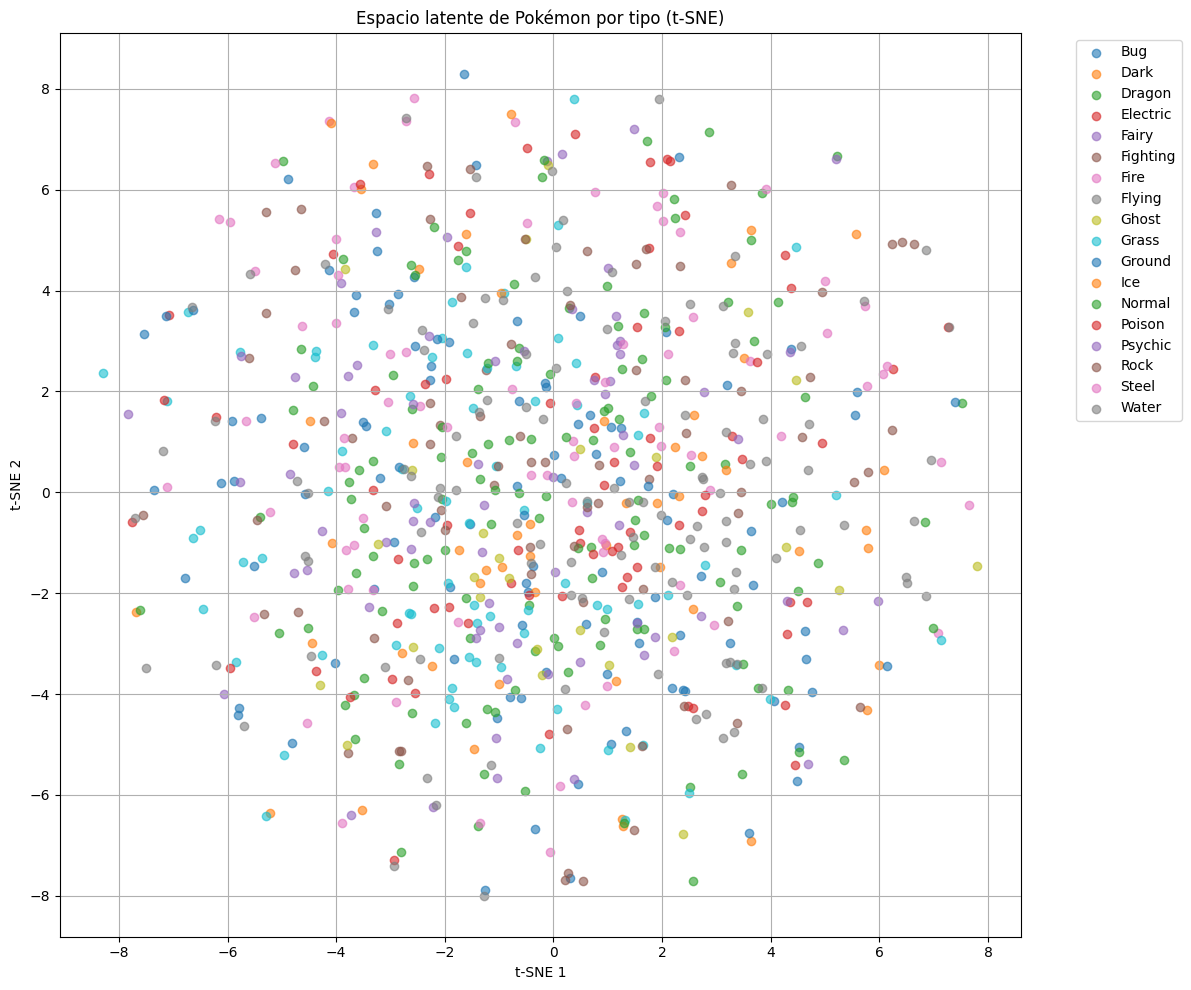

In [ ]:
dataset = PokemonDataset(csv_path, img_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
plot_latent_space_tsne(vae, dataloader, dataset.label_encoder, device='cuda')

In [ ]:
def generate_pokemon(model, num_samples=10, device='cuda'):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        samples = model.decode(z).cpu()

    grid = torch.cat([img for img in samples], dim=2)  # concatena horizontal
    plt.figure(figsize=(15, 5))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title("Pokémon generados desde el espacio latente")
    plt.show()


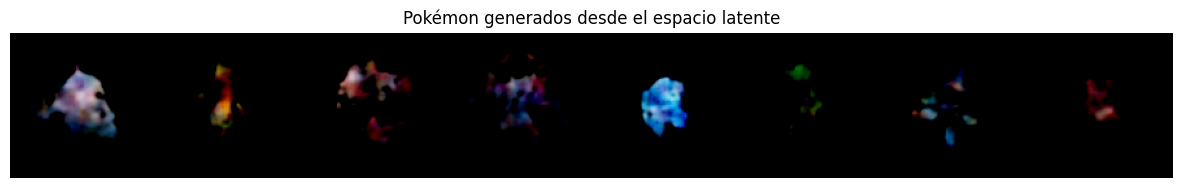

In [ ]:
generate_pokemon(vae, num_samples=8, device='cuda')

***Devolución***

Se señaló la importancia de generar imágenes que representen puntos intermedios dentro del espacio latente. Aunque este espacio no es directamente interpretable de forma clara, una estrategia viable consiste en agrupar las imágenes por tipo —por ejemplo, todas las del tipo fuego—, y calcular el centro de masa de dicho grupo. Este punto puede tomarse como referencia para generar nuevas instancias que conserven las características generales del tipo.

En esta parte, se resalta la importancia del vector latente z, que se obtiene aplicando una técnica de reparametrización. Este proceso consiste en tomar la distribución generada por el encoder (normalmente una distribución estándar) y, a partir de ella, obtener una muestra que permita reconstruir una imagen. Es importante identificar los valores mínimos (min) y los logaritmos correspondientes que devuelve el encoder, ya que estos definen el comportamiento del modelo al momento de generar variaciones.

Se propone también evaluar la calidad de los clusters mediante métricas específicas, y a partir de estos resultados, mejorar la estrategia general de generación. Una forma de hacerlo es probar el sistema completo: tomar una imagen, pasarla por el encoder y luego por el decoder, verificando si el resultado reconstruido mantiene la coherencia esperada.

Por otra parte, se encuentra la función de pérdida. Se recomienda aumentar el peso de la parte correspondiente a la reconstrucción, lo cual deberia mejorar la calidad de las imágenes generadas. Se sugiere experimentar con diferentes configuraciones, por ejemplo, un modelo con una relación de 50/50 entre reconstrucción y generación, y otro con un factor 10x para favorecer la reconstrucción.

Adicionalmente, se puede trabajar en una generación más "inteligente". Por ejemplo, al tomar un Pokémon y codificarlo, se puede usar su vector latente como base para generar múltiples variantes. También se puede calcular los 20 puntos más cercanos dentro del espacio latente y obtener un promedio entre ellos, lo que daría lugar a una generación más controlada y centrada.

Finalmente, se propone aplicar el guardado automático: un script que se encarge de hacer la comparación de los modelos entrenados y conserve el mejor de ellos en el entorno de trabajo, de modo que pueda reutilizardo directamente por la aplicación.

Para finalizar, el profesor sugiere incorporar un gráfico de evolución de la función de pérdida durante el entrenamiento, con el objetivo de visualizar claramente las mejoras obtenidas a lo largo del tiempo.



---



---



#**Cuarta Entrega**


---



---



# Carga de Dataset y DataLoader Pokemon

Importaciones iniciales

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
import kagglehub

Se descarga el Dataset desde la pagina de Kaggle

In [ ]:
path = kagglehub.dataset_download("vishalsubbiah/pokemon-images-and-types")
print("Path to dataset files:", path)

En caso de necesitar tomar el DataSet desde Drive, se monta la conexion a Drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Definimos los path donde se encuentran las imágenes y las etiquetas

In [ ]:
#Path drive
# dataset_path = "/content/drive/My Drive/RedesNeuronales"

#Path Kaggle
csv_path = path + "/pokemon.csv"
img_path = path + "/images"

Definimos los métodos del DataSet

In [ ]:
import os
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image

class PokemonDataset(Dataset):
    #Caso multietiqueta
    # def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
    #     self.img_labels = pd.read_csv(csv_file)
    #     self.img_labels.fillna("Null", inplace=True)
    #     self.img_dir = img_dir
    #     self.transform = transform
    #     self.target_transform = target_transform

    #     multilabel_data = self.img_labels[['Type1', 'Type2', 'Evolution']].values.tolist()

    #     self.label_encoder = MultiLabelBinarizer()
    #     self.labels = self.label_encoder.fit_transform(multilabel_data)

    def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    #Caso multietiqueta
    # def __getitem__(self, idx):
    #     img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+ ".png")
    #     image = Image.open(img_path).convert("RGB")
    #     label = torch.tensor(self.labels[idx]).float() #self.img_labels.iloc[idx, 1]
    #     if self.transform:
    #         image = self.transform(image)
    #     if self.target_transform:
    #         label = self.target_transform(label)
    #     return image, label

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0]+ ".png")
        image = Image.open(img_path).convert("RGB")
        label = self.img_labels.iloc[idx, 1] # se decide usar la etiqueta uno del pokemon al ser la mas representativa (1 tipo)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

    #Caso multietiqueta
    # def get_classes(self):
    #     return self.label_encoder.classes_

Realizamos la tranformación de las imagenes para que todas tengan el tamaño de 120x120

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((120, 120)),
])

Y cargamos el DataSet

In [ ]:
pokemon_dataset = PokemonDataset(csv_file=csv_path, img_dir=img_path, transform=transform)

Hacemos pruebas para ver que se haya cargado correctamente

In [ ]:
print("Cantidad total de datos:", len(pokemon_dataset))

Cantidad total de datos: 809


In [ ]:
#Caso multietiqueta
# img, label = pokemon_dataset[0]
# tipos = [cls for cls, val in zip(pokemon_dataset.get_classes(), label) if val == 1]
# print("Tipos y evolución:", tipos)

Pruebas solo para el caso de una sola etiqueta

In [ ]:
img, label, name = pokemon_dataset[0]
print("Forma de la imagen:", img.shape)
print("Etiquetas:", label)
print("Nombre:", name)

Forma de la imagen: torch.Size([3, 120, 120])
Etiquetas: Grass
Nombre: bulbasaur


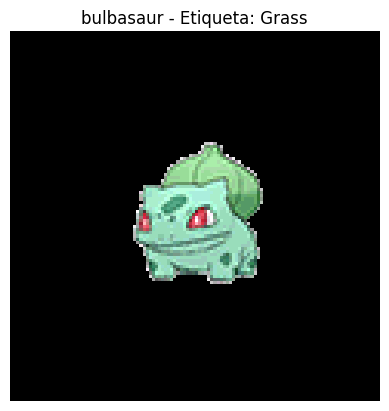

In [ ]:
import matplotlib.pyplot as plt
img_np = img.permute(1, 2, 0).numpy()

plt.imshow(img_np)
plt.title(name + " - " + "Etiqueta: " + label)
plt.axis("off")
plt.show()

Generamos el DataLoader y vemos una de sus imágenes

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(pokemon_dataset, batch_size=64, shuffle=True)

In [ ]:
#Caso multietiqueta
# import matplotlib.pyplot as plt

# train_features, train_labels = next(iter(train_dataloader))

# print(f"Shape de imágenes (batch): {train_features.shape}")
# print(f"Shape de etiquetas (batch): {train_labels.shape}")

# img = train_features[0].permute(1, 2, 0)
# label_vector = train_labels[0]

# plt.imshow(img)
# plt.axis("off")
# plt.show()

# active_labels = [cls for cls, v in zip(pokemon_dataset.get_classes(), label_vector) if v == 1]
# print("Tipos y evolución:", active_labels)

Solo para el caso de una sola etiqueta

Shape del batch de imágenes: torch.Size([64, 3, 120, 120])


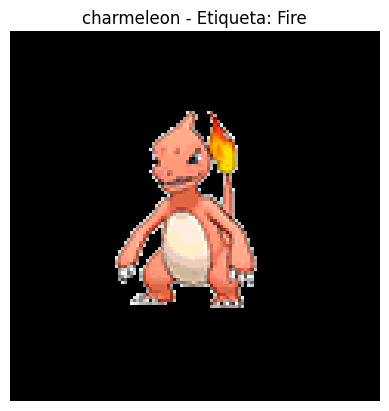

In [ ]:
import matplotlib.pyplot as plt

train_features, train_labels, train_names = next(iter(train_dataloader))

print(f"Shape del batch de imágenes: {train_features.shape}")

img = train_features[0].permute(1, 2, 0)
label = train_labels[0]
name = train_names[0]

plt.imshow(img)
plt.axis("off")
plt.title(f"{name} - Etiqueta: {label}")
plt.show()

# print(f"Label: {label}")

# Creación modelo VAE

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Variational_Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Variational_Encoder, self).__init__()
        self.flattened_size = 3 * 120 * 120  # por las imágenes 120x120 RGB
        self.linear1 = nn.Linear(self.flattened_size, 1024)
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, latent_dims)  # media
        self.linear4 = nn.Linear(512, latent_dims)  # log_var

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        z = F.relu(self.linear2(x))
        media = self.linear3(z)
        log_var = self.linear4(z)
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        latente = eps * std + media
        return latente, media, log_var


In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 1024)
        self.linear3 = nn.Linear(1024, 3 * 120 * 120)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = F.relu(self.linear2(z))
        z = torch.sigmoid(self.linear3(z))
        return z.view(-1, 3, 120, 120)  # reconstruimos imagen RGB 120x120

In [ ]:
class Variational_Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Variational_Autoencoder, self).__init__()
        self.encoder = Variational_Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z, media, log_var = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, media, log_var

In [ ]:
class CenterLoss(nn.Module):
    def __init__(self, num_classes, feat_dim):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.centers = nn.Parameter(torch.randn(num_classes, feat_dim))

    def forward(self, features, labels):
        batch_size = features.size(0)
        centers_batch = self.centers[labels]
        loss = (features - centers_batch).pow(2).sum() / 2.0 / batch_size
        return loss

In [ ]:
def vae_loss_con_center_loss(x, x_hat, mu, log_var, z, labels, center_loss_fn, alpha=1.0):
    # 1. Pérdida de reconstrucción
    reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')

    # 2. Pérdida KL Divergence
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    # 3. Center loss (agrupa por tipo)
    center_loss = center_loss_fn(z, labels)

    total_loss = reconstruction_loss + kl_loss + alpha * center_loss
    return total_loss, reconstruction_loss, kl_loss, center_loss


In [ ]:
from collections import defaultdict
import random

class BalancedPokemonDataset(Dataset):
    def __init__(self, base_dataset, max_per_type=100):
        self.samples = []
        counter = defaultdict(int)

        for img, label in base_dataset:
            if counter[label] < max_per_type:
                self.samples.append((img, label))
                counter[label] += 1

        random.shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [ ]:
balanced_dataset = BalancedPokemonDataset(pokemon_dataset, max_per_type=80)
balanced_loader = DataLoader(balanced_dataset, batch_size=64, shuffle=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder

def train(autoencoder, dataloader, epochs=20, save_path='best_vae.pth'):
    label_encoder = LabelEncoder()
    all_labels = [label for _, label in dataloader.dataset]
    label_encoder.fit(all_labels)
    num_classes = len(label_encoder.classes_)

    center_loss_fn = CenterLoss(num_classes=num_classes, feat_dim=autoencoder.encoder.linear3.out_features).to(device)
    opt = Adam(list(autoencoder.parameters()) + list(center_loss_fn.parameters()), lr=1e-3)

    best_loss = float('inf')

    for epoch in range(epochs):
        autoencoder.train()
        total_loss = 0.0
        total_pixels = 0

        for x, label in dataloader:
            x = x.to(device)
            encoded_labels = torch.tensor(label_encoder.transform(label)).to(device)

            opt.zero_grad()
            z, mu, log_var = autoencoder.encoder(x)
            x_hat = autoencoder.decoder(z)

            loss, recon_loss, kl_loss, c_loss = vae_loss_con_center_loss(
                x, x_hat, mu, log_var, z, encoded_labels, center_loss_fn
            )

            loss.backward()
            opt.step()

            total_loss += loss.item()
            total_pixels += x.numel()

        avg_loss = total_loss / total_pixels
        print(f"[Epoch {epoch+1}/{epochs}] Total: {avg_loss:.6f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(autoencoder.state_dict(), save_path)
            print("✅ Mejor modelo actualizado.")

    return label_encoder  # lo necesitamos para los siguientes pasos


In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

def visualizar_latentes(vae, dataloader, label_encoder, metodo="tsne", cantidad_max=1000):
    vae.eval()
    z_list = []
    label_list = []

    with torch.no_grad():
        total = 0
        for x, label in dataloader:
            x = x.to(device)
            encoded_labels = label_encoder.transform(label)
            z, _, _ = vae.encoder(x)

            z_list.append(z.cpu())
            label_list.extend(encoded_labels)

            total += len(x)
            if total >= cantidad_max:
                break

    z_all = torch.cat(z_list, dim=0).numpy()
    label_array = np.array(label_list)

    # Reducción de dimensión
    if metodo == "tsne":
        z_2D = TSNE(n_components=2, perplexity=30, learning_rate=200, n_iter=1000).fit_transform(z_all)
    elif metodo == "pca":
        z_2D = PCA(n_components=2).fit_transform(z_all)
    else:
        raise ValueError("Método de reducción no válido: tsne o pca")

    # Normalización opcional
    z_2D = (z_2D - z_2D.min(0)) / (z_2D.max(0) - z_2D.min(0))

    # Gráfico
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(z_2D[:, 0], z_2D[:, 1], c=label_array, cmap="tab20", s=12)

    # Leyenda
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w',
               label=f'{i}: {label}',
               markerfacecolor=plt.cm.tab20(i % 20), markersize=8)
        for i, label in enumerate(label_encoder.classes_)
    ]
    plt.legend(handles=legend_elements, title="Tipo de Pokémon", bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.title(f"Espacio latente con agrupación por tipo ({metodo.upper()})")
    plt.xlabel("Latente 1")
    plt.ylabel("Latente 2")
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


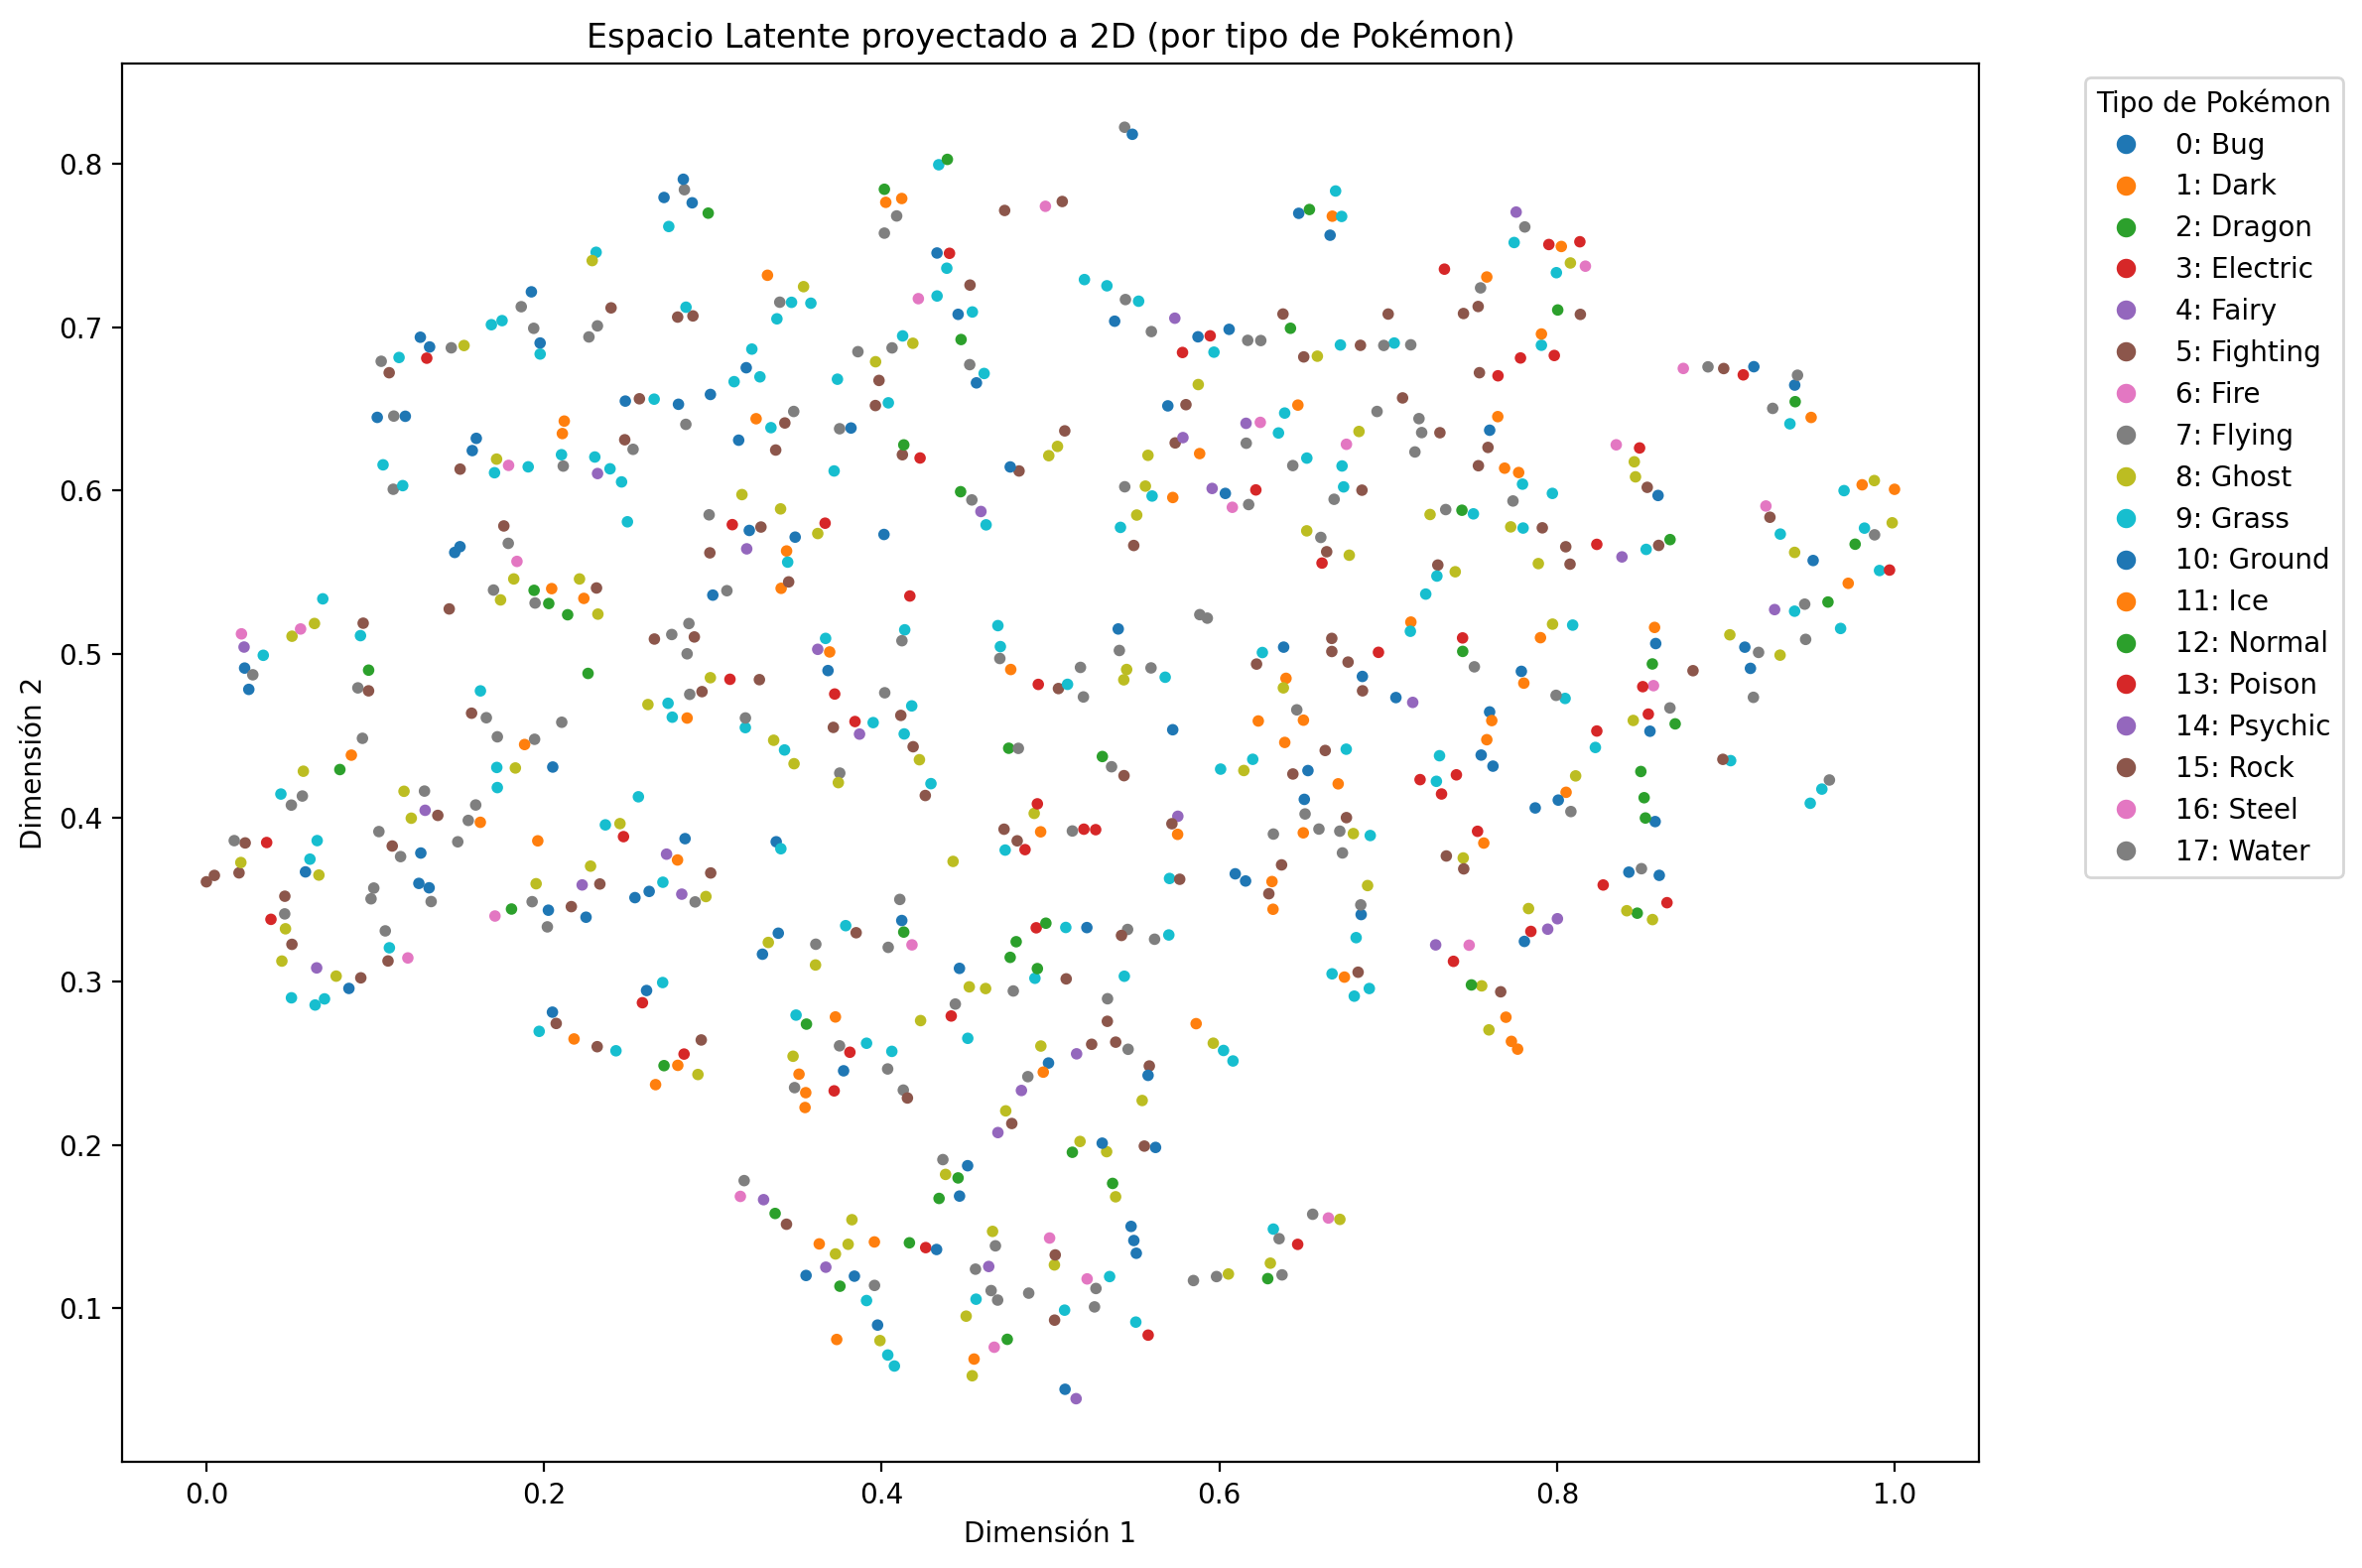

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Paso 1: Obtenemos vectores latentes y etiquetas
z_list = []
label_list = []

for i, (x, label) in enumerate(train_dataloader):
    if i >= 16:  # Hasta ~1024 imágenes
        break
    x = x.to(device)
    z, _, _ = vae.encoder(x)
    z_list.append(z.detach().cpu())
    label_list.extend(label)  # Esto son strings tipo "Water", "Fire", etc.

z_all = torch.cat(z_list, dim=0)

# Paso 2: Convertir etiquetas a números con LabelEncoder
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(label_list)  # Cada tipo tiene un número único

# Paso 3: TSNE para reducción a 2D
if z_all.shape[1] == 2:
    z_2D = z_all.numpy()
else:
    tsne = TSNE(n_components=2, perplexity=10, learning_rate=100, n_iter=3000, random_state=42)
    z_2D = tsne.fit_transform(z_all.numpy())

# Paso 4: Normalización (opcional)
z_2D = (z_2D - z_2D.min()) / (z_2D.max() - z_2D.min())

# Paso 5: Graficar
plt.figure(figsize=(12, 8))
scatter = plt.scatter(z_2D[:, 0], z_2D[:, 1], c=numeric_labels, cmap="tab10", s=10)
plt.title("Espacio Latente proyectado a 2D (por tipo de Pokémon)")
plt.xlabel("Dimensión 1")
plt.ylabel("Dimensión 2")

# Leyenda personalizada sin colorbar
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w',
           label=f'{i}: {label}',
           markerfacecolor=plt.cm.tab10(i % 10), markersize=8)
    for i, label in enumerate(label_encoder.classes_)
]
plt.legend(handles=legend_elements, title="Tipo de Pokémon", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# label_encoder = train(vae, train_dataloader, epochs=200)
# visualizar_latentes(vae, train_dataloader, label_encoder, metodo="tsne")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # vae = Variational_Autoencoder(latent_dims=10).to(device)
# # label_encoder = train(vae, balanced_loader, epochs=30)
vae = Variational_Autoencoder(latent_dims=10).to(device)
label_encoder = train(vae, balanced_loader, epochs=30)

[Epoch 1/30] Total: 0.086812
✅ Mejor modelo actualizado.
[Epoch 2/30] Total: 0.039836
✅ Mejor modelo actualizado.
[Epoch 3/30] Total: 0.034342
✅ Mejor modelo actualizado.
[Epoch 4/30] Total: 0.032418
✅ Mejor modelo actualizado.
[Epoch 5/30] Total: 0.031423
✅ Mejor modelo actualizado.
[Epoch 6/30] Total: 0.030466
✅ Mejor modelo actualizado.
[Epoch 7/30] Total: 0.029661
✅ Mejor modelo actualizado.
[Epoch 8/30] Total: 0.029098
✅ Mejor modelo actualizado.
[Epoch 9/30] Total: 0.028521
✅ Mejor modelo actualizado.
[Epoch 10/30] Total: 0.027698
✅ Mejor modelo actualizado.
[Epoch 11/30] Total: 0.027081
✅ Mejor modelo actualizado.
[Epoch 12/30] Total: 0.026697
✅ Mejor modelo actualizado.
[Epoch 13/30] Total: 0.026252
✅ Mejor modelo actualizado.
[Epoch 14/30] Total: 0.025905
✅ Mejor modelo actualizado.
[Epoch 15/30] Total: 0.025779
✅ Mejor modelo actualizado.
[Epoch 16/30] Total: 0.025306
✅ Mejor modelo actualizado.
[Epoch 17/30] Total: 0.024814
✅ Mejor modelo actualizado.
[Epoch 18/30] Total: 0.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


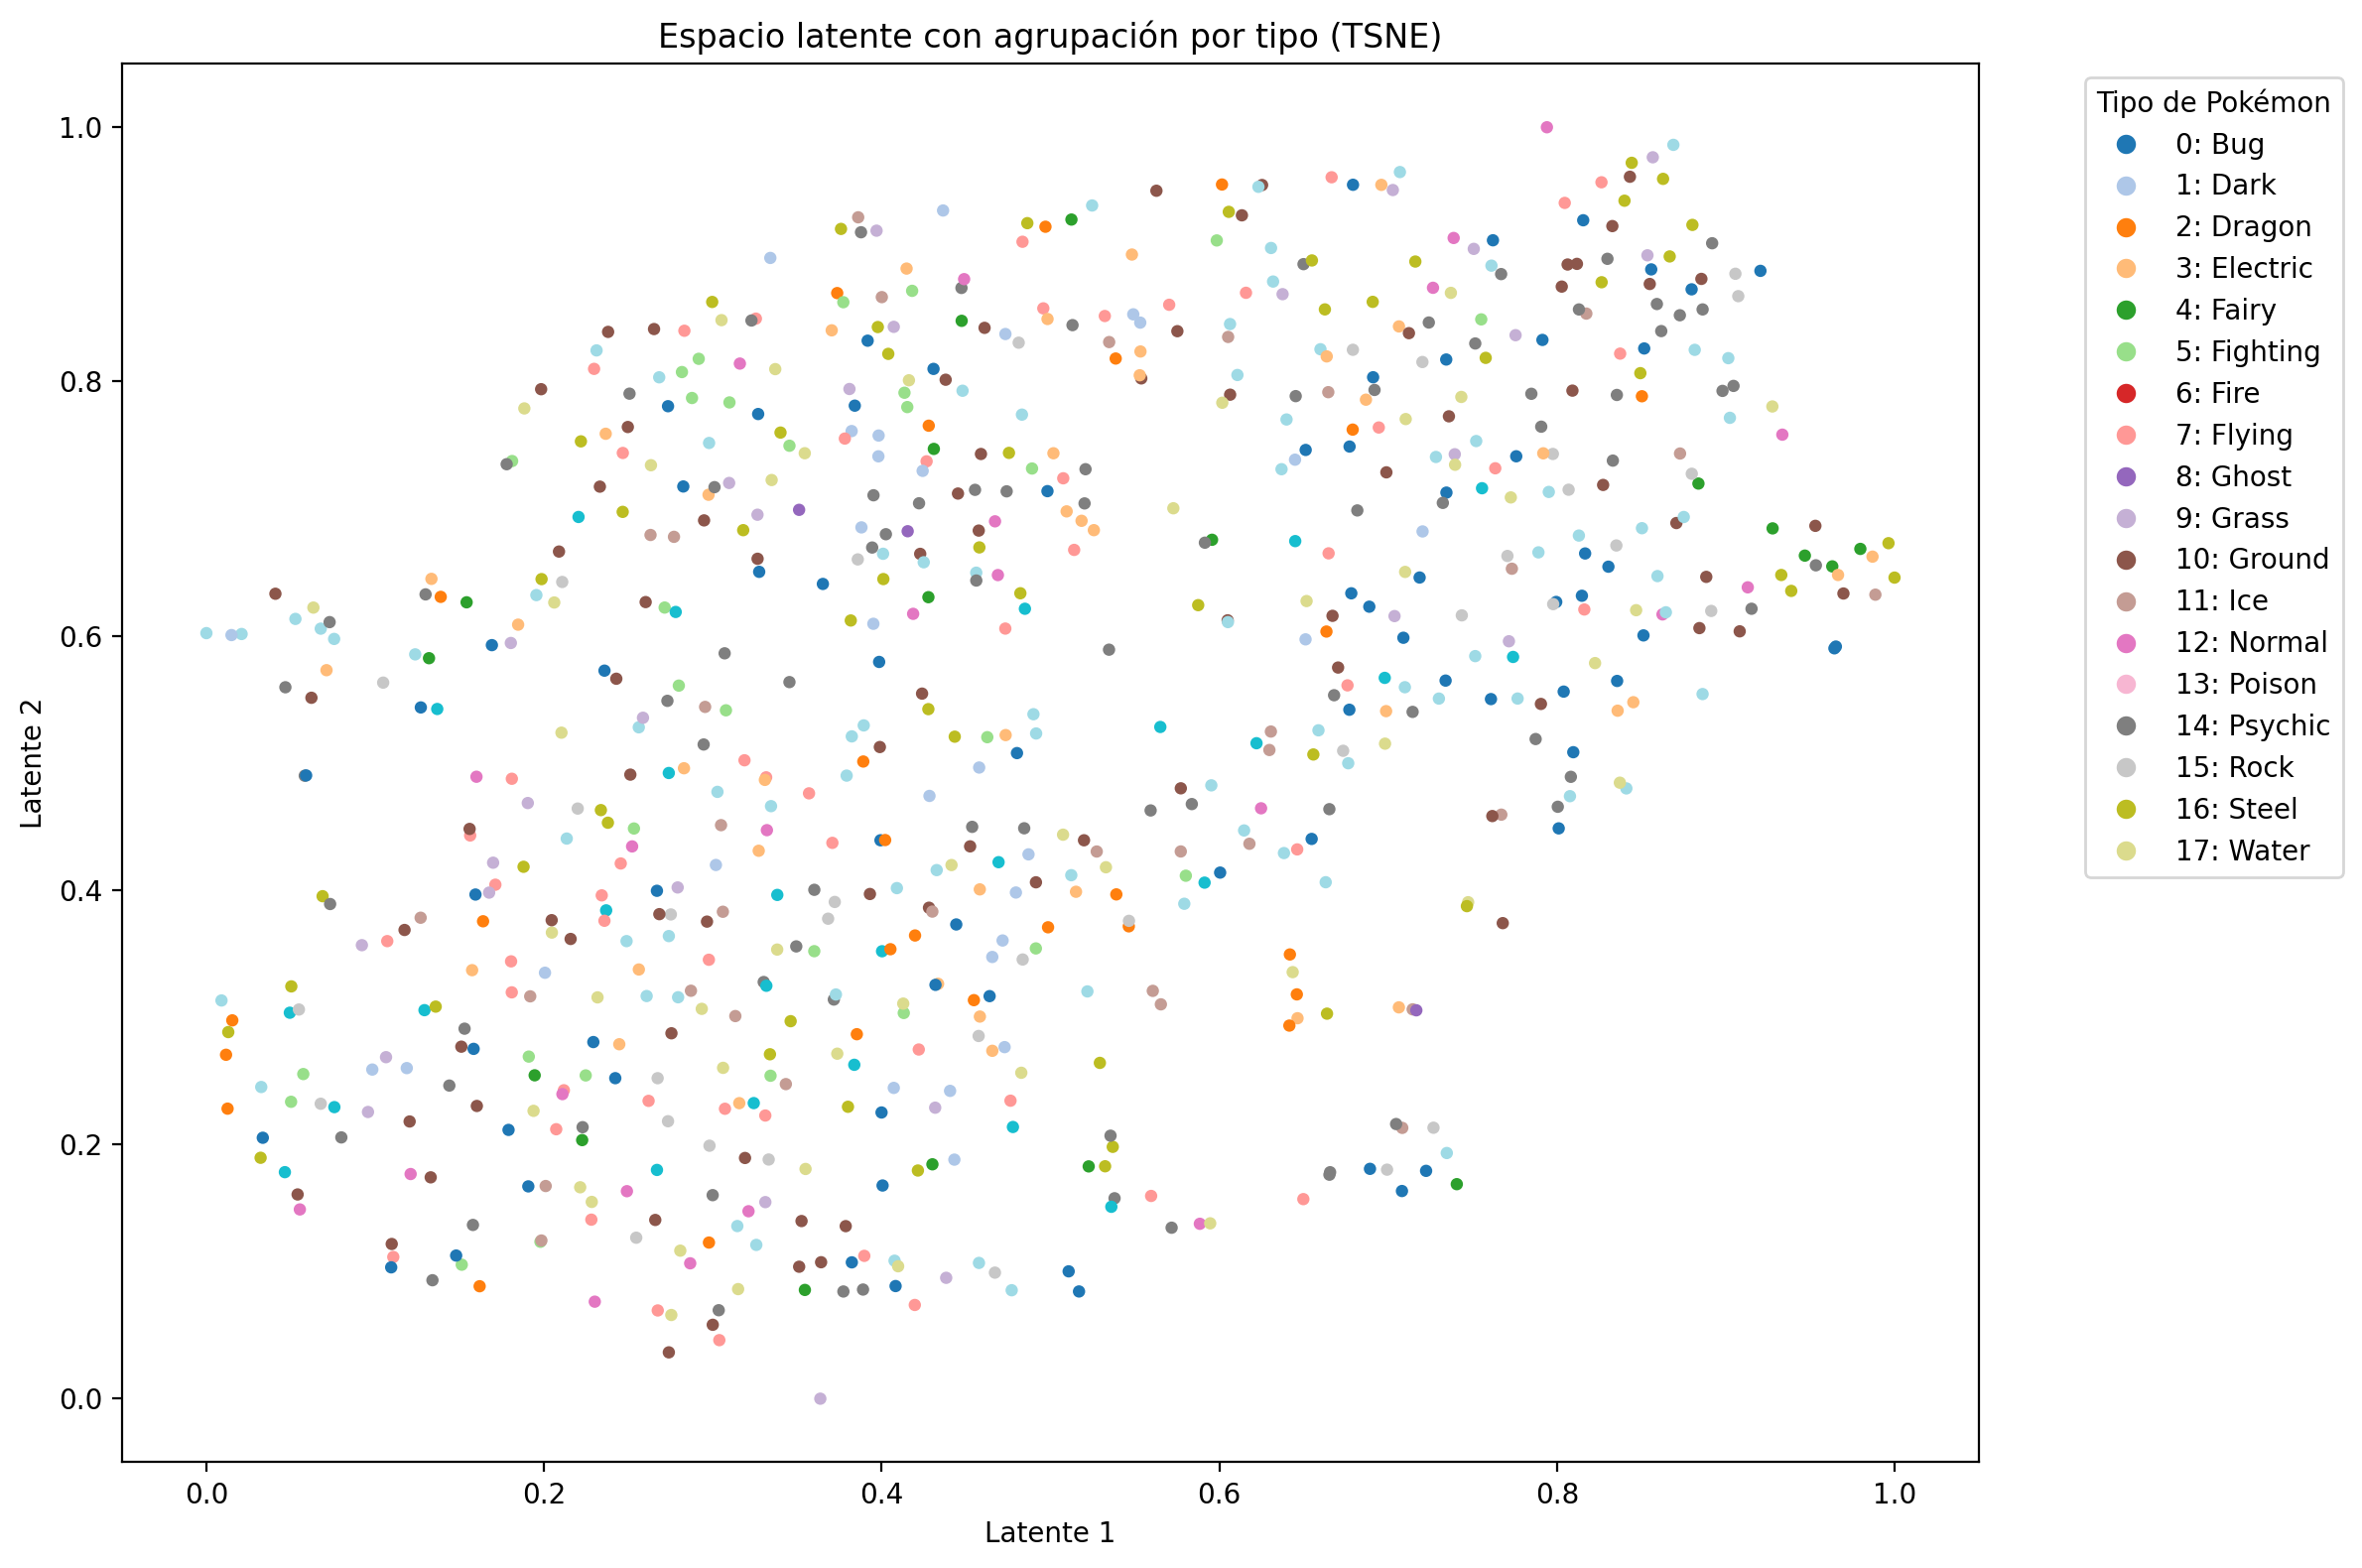

In [ ]:
visualizar_latentes(vae, balanced_loader, label_encoder, metodo="tsne")

In [ ]:
def generar_pokemones_por_tipo(vae, dataset, tipo_deseado, cantidad=5):
    vae.eval()
    embeddings = []

    # Paso 1: filtrar imágenes por tipo deseado
    for i in range(len(dataset)):
        img, label = dataset[i]
        if label.lower() == tipo_deseado.lower():
            img = img.unsqueeze(0).to(device)
            with torch.no_grad():
                z, _, _ = vae.encoder(img)
            embeddings.append(z.cpu())

    if len(embeddings) == 0:
        print(f"No se encontraron Pokémon del tipo {tipo_deseado}")
        return

    embeddings = torch.cat(embeddings, dim=0)

    print(f"Generando {cantidad} Pokémon nuevos a partir de {len(embeddings)} ejemplos del tipo {tipo_deseado}.")

    nuevos_pokemones = []
    for _ in range(cantidad):
        # Elegir 2 embeddings al azar y hacer interpolación lineal
        idx_a, idx_b = torch.randint(0, len(embeddings), (2,))
        a, b = embeddings[idx_a], embeddings[idx_b]
        alpha = torch.rand(1).item()
        z_nuevo = alpha * a + (1 - alpha) * b

        # Decodificar
        with torch.no_grad():
            img_nueva = vae.decoder(z_nuevo.to(device)).cpu().squeeze().permute(1, 2, 0).numpy()
            nuevos_pokemones.append(img_nueva)

    # Mostrar imágenes generadas
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, cantidad, figsize=(15, 3))
    for i, img in enumerate(nuevos_pokemones):
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.suptitle(f"Nuevos Pokémon tipo {tipo_deseado}")
    plt.show()

Generando 5 Pokémon nuevos a partir de 72 ejemplos del tipo bug.


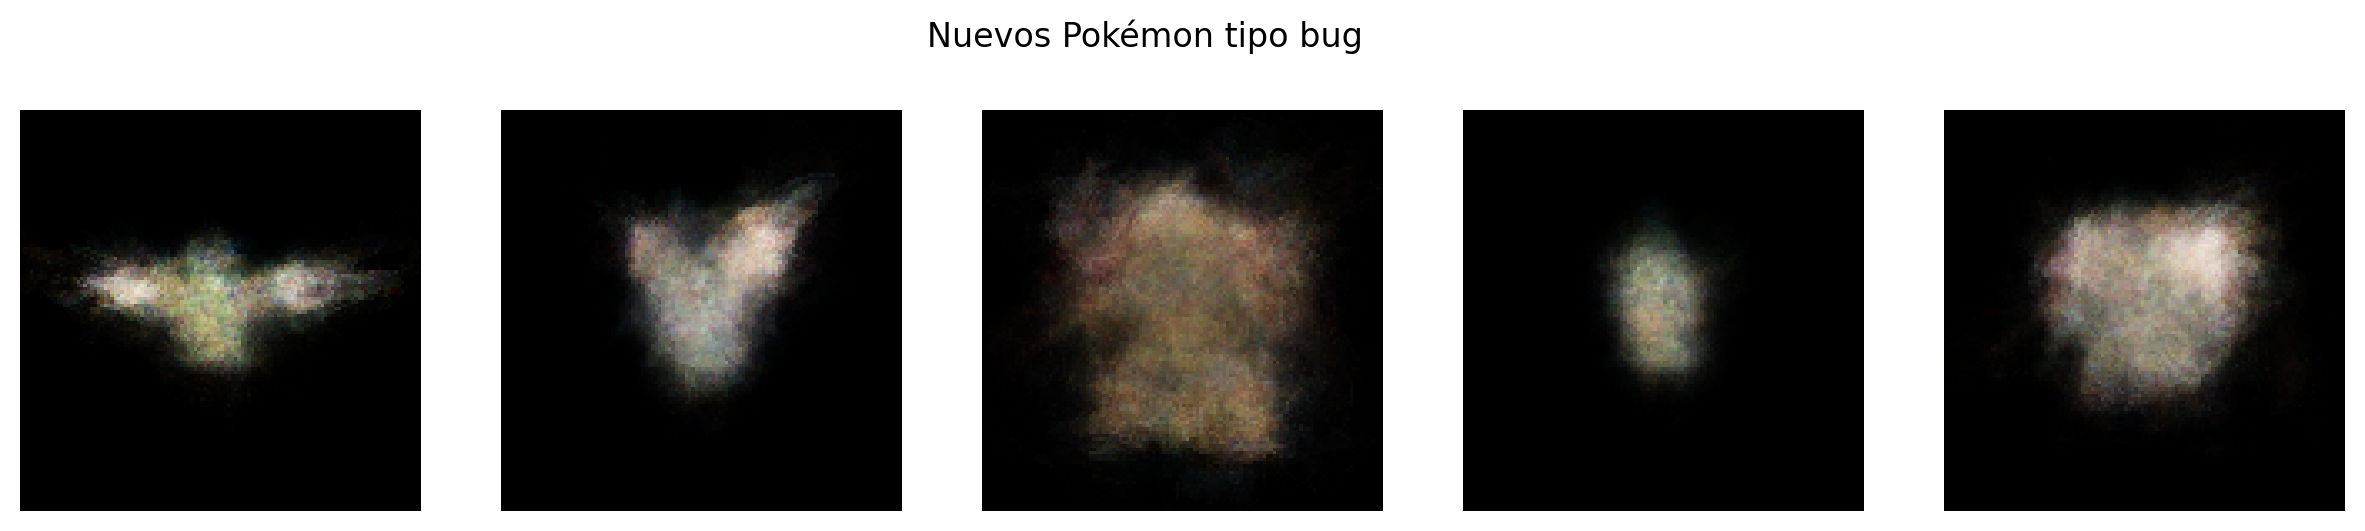

In [ ]:
generar_pokemones_por_tipo(vae, pokemon_dataset, tipo_deseado="bug", cantidad=5)

# CVAE


In [ ]:
import torch;
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#establece la semilla para que los generadores aleatorios sean consistentes entre corridas
torch.manual_seed(0)

#establece cuántas dimensiones tendrá el espacio latente
codings_size = 30

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, latent_dims, num_classes):
        super(Encoder, self).__init__()

        # Capas convolucionales
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1)   # 120x120 → 60x60
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # 60x60 → 30x30
        self.conv3 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1) # 30x30 → 15x15
        self.conv4 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)# 15x15 → 8x8

        self.flatten = nn.Flatten()

        # Cálculo automático del tamaño plano
        with torch.no_grad():
            dummy_x = torch.zeros(1, 3, 120, 120)  # imagen dummy
            x = F.relu(self.conv1(dummy_x))
            x = F.relu(self.conv2(x))
            x = F.relu(self.conv3(x))
            x = F.relu(self.conv4(x))
            flat_dim = x.view(1, -1).shape[1] + num_classes  # suma el tipo one-hot

        # Capas lineales
        self.fc1 = nn.Linear(flat_dim, 512)
        self.fc2_mu = nn.Linear(512, latent_dims)
        self.fc2_logvar = nn.Linear(512, latent_dims)

    def forward(self, x, labels_onehot):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.flatten(x)
        x = torch.cat([x, labels_onehot], dim=1)
        h = F.relu(self.fc1(x))
        return self.fc2_mu(h), self.fc2_logvar(h)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
    def __init__(self, latent_dims, num_classes):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dims + num_classes, 256 * 8 * 8)

        self.deconv1 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1)  # 8x8 -> 16x16
        self.deconv2 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)   # 16x16 -> 32x32
        self.deconv3 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)    # 32x32 -> 64x64
        self.deconv4 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)     # 64x64 -> 128x128
        self.crop = nn.Identity()  # te muestro luego cómo recortar a 120x120 si sobra

    def forward(self, z, labels_onehot):
        x = torch.cat([z, labels_onehot], dim=1)
        x = F.relu(self.fc(x))
        x = x.view(-1, 256, 8, 8)
        x = F.relu(self.deconv1(x))  # (B, 128, 16, 16)
        x = F.relu(self.deconv2(x))  # (B, 64, 32, 32)
        x = F.relu(self.deconv3(x))  # (B, 32, 64, 64)
        x = torch.sigmoid(self.deconv4(x))  # (B, 3, 128, 128)

        # Recortamos a 120x120 si querés exacto:
        x = x[:, :, 4:124, 4:124]  # (B, 3, 120, 120)
        return x

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dims, num_classes):
        super(ConditionalVAE, self).__init__()
        self.latent_dims = latent_dims        # Guardamos la dimensión latente
        self.num_classes = num_classes        # Guardamos la cantidad de clases (tipos)
        self.encoder = Encoder(latent_dims, num_classes)
        self.decoder = Decoder(latent_dims, num_classes)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, labels_onehot):
        mu, logvar = self.encoder(x, labels_onehot)       # Encoder condicional
        z = self.reparameterize(mu, logvar)               # Reparametrización
        x_recon = self.decoder(z, labels_onehot)          # Decoder condicional
        return x_recon, mu, logvar

In [ ]:
def cvae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')  # o F.binary_cross_entropy para datos [0,1]
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [ ]:
def train(cvae, data, label_encoder, onehot_encoder, epochs=20):
    cvae.train()
    opt = torch.optim.Adam(cvae.parameters())

    for epoch in range(epochs):
        total_loss = 0.0
        total_pixels = 0

        for x, y in data:
            x = x.to(device)  # (B, 3, 120, 120)

            # Paso 1: Codificar etiquetas a one-hot
            y_encoded = label_encoder.transform(y)  # int labels
            y_onehot = onehot_encoder.transform(y_encoded.reshape(-1, 1))
            y_onehot = torch.tensor(y_onehot, dtype=torch.float32).to(device)  # (B, num_classes)

            # Paso 2: Forward + pérdida
            opt.zero_grad()
            x_hat, mu, logvar = cvae(x, y_onehot)
            loss = cvae_loss(x_hat, x, mu, logvar)

            # Paso 3: Backprop y optimización
            loss.backward()
            opt.step()

            total_loss += loss.item()
            total_pixels += x.numel()

        print(f"Epoch {epoch+1}, Loss: {(total_loss / total_pixels):.6f}")

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

all_labels = []
for i in range(len(pokemon_dataset)):
    _, label = pokemon_dataset[i]
    all_labels.append(label)

label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False)  # <- corregido

y_encoded = label_encoder.fit_transform(all_labels)
y_onehot = onehot_encoder.fit_transform(y_encoded.reshape(-1, 1))

# Inicializar modelo
latent_dims = 20
num_classes = len(label_encoder.classes_)
cvae = ConditionalVAE(latent_dims, num_classes).to(device)

# Entrenar
train(cvae, train_dataloader, label_encoder, onehot_encoder, epochs=20)

Epoch 1, Loss: 0.139242
Epoch 2, Loss: 0.064385
Epoch 3, Loss: 0.058510
Epoch 4, Loss: 0.040212
Epoch 5, Loss: 0.036596
Epoch 6, Loss: 0.034736
Epoch 7, Loss: 0.033644
Epoch 8, Loss: 0.032758
Epoch 9, Loss: 0.032190
Epoch 10, Loss: 0.031642
Epoch 11, Loss: 0.031151
Epoch 12, Loss: 0.030744
Epoch 13, Loss: 0.029746
Epoch 14, Loss: 0.028982
Epoch 15, Loss: 0.028209
Epoch 16, Loss: 0.027379
Epoch 17, Loss: 0.026852
Epoch 18, Loss: 0.026305
Epoch 19, Loss: 0.025686
Epoch 20, Loss: 0.024965


In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space(cvae, dataloader, label_encoder, device, num_batches=100):
    cvae.eval()
    zs = []
    labels = []

    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            if i > num_batches:
                break
            x = x.to(device)

            # Convertir etiquetas a one-hot para alimentar encoder
            y_encoded = label_encoder.transform(y)
            y_onehot = torch.zeros(len(y_encoded), len(label_encoder.classes_)).to(device)
            y_onehot.scatter_(1, torch.tensor(y_encoded).unsqueeze(1).to(device), 1)

            mu, _ = cvae.encoder(x, y_onehot)
            zs.append(mu.cpu().numpy())
            labels.extend(y_encoded)

    zs = np.concatenate(zs, axis=0)
    labels = np.array(labels)

    plt.figure(figsize=(8,6))
    scatter = plt.scatter(zs[:,0], zs[:,1], c=labels, cmap='tab20', alpha=0.7, s=10)
    plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)))
    plt.title('Espacio latente (mu) de CVAE')
    plt.xlabel('Latent dim 1')
    plt.ylabel('Latent dim 2')
    plt.show()

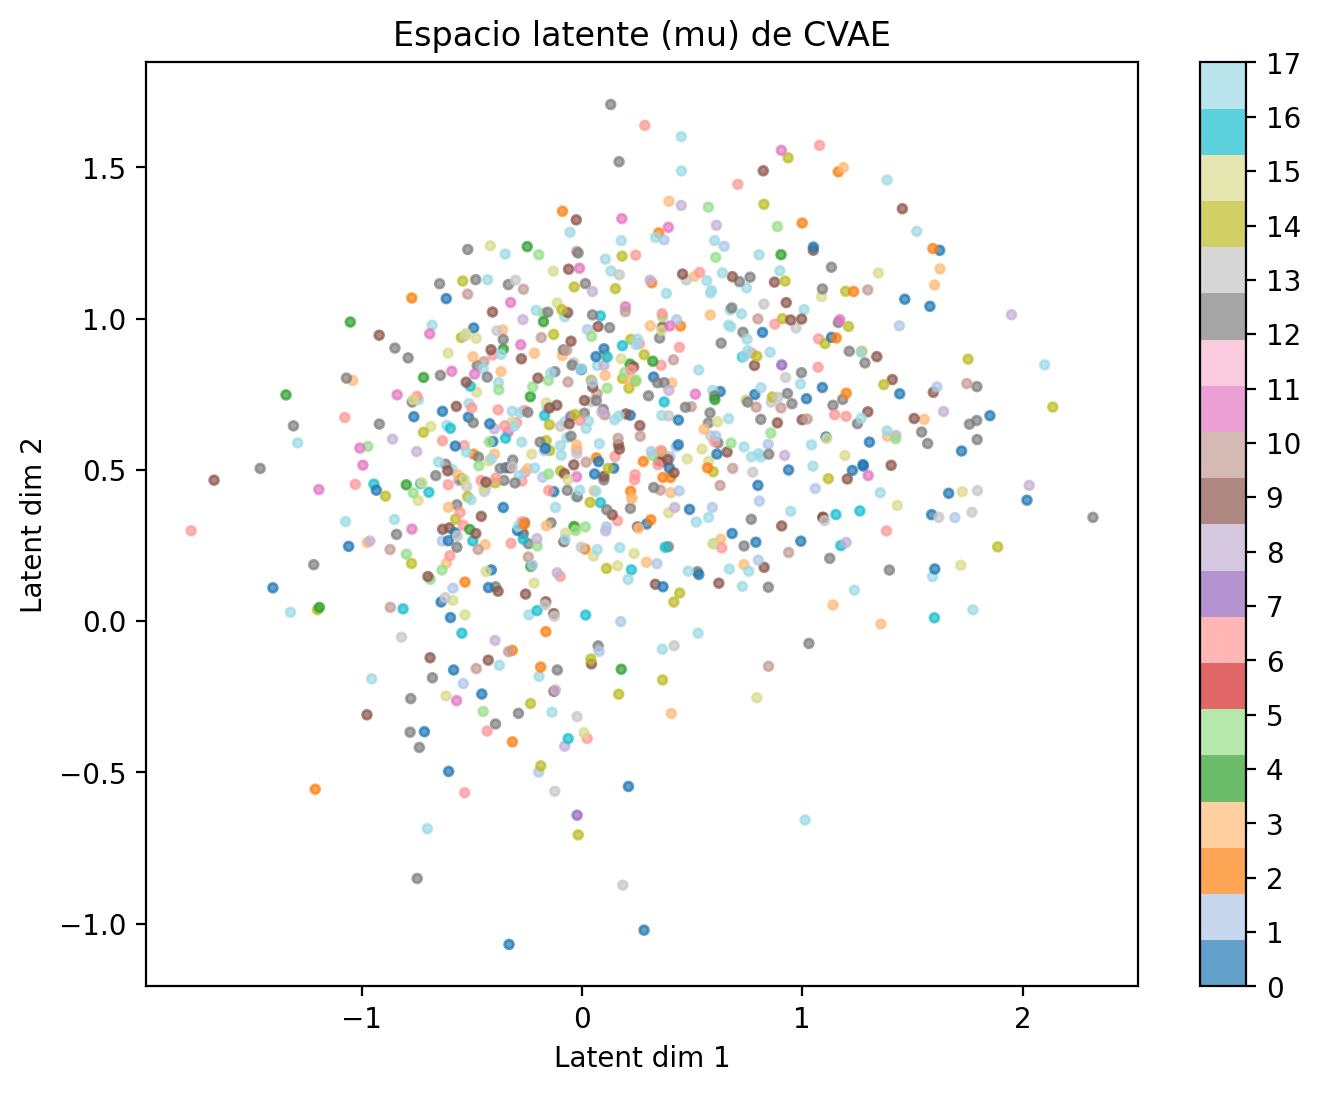

In [ ]:
plot_latent_space(cvae, train_dataloader, label_encoder, device)

In [ ]:
def generate_pokemons(cvae, label_encoder, tipo_nombre, n=5, device='cpu'):
    cvae.eval()
    tipo_idx = label_encoder.transform([tipo_nombre])[0]

    # One-hot para el tipo elegido
    tipo_onehot = torch.zeros((n, len(label_encoder.classes_)), device=device)
    tipo_onehot[:, tipo_idx] = 1

    # Muestreamos z ~ N(0,1)
    z = torch.randn(n, cvae.latent_dims, device=device)

    # Generamos imágenes
    with torch.no_grad():
        imgs = cvae.decoder(z, tipo_onehot)

    imgs = imgs.cpu()

    # Mostrar imágenes
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    for i in range(n):
        ax = axes[i]
        img = imgs[i].permute(1,2,0).numpy()
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"{tipo_nombre} #{i+1}")
    plt.show()

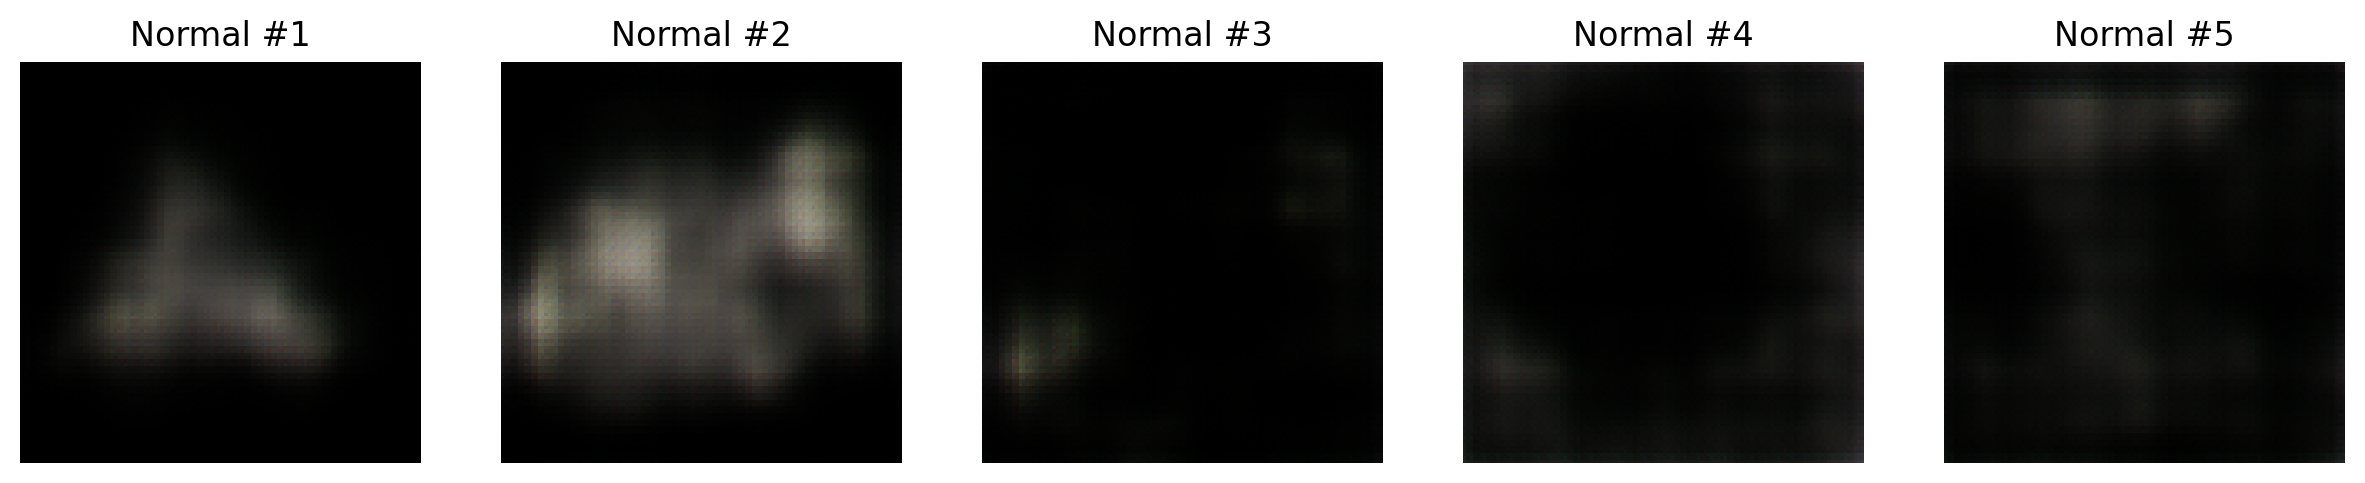

In [ ]:
generate_pokemons(cvae, label_encoder, "Normal", n=5, device=device)

# Ultimo intento

In [ ]:
import pandas as pd

# Cargar CSV para análisis (fuera del Dataset)
df = pd.read_csv(csv_path)

# Contar cuántos Pokémon hay de cada tipo1
conteo_tipo1 = df['Type1'].value_counts()

print("Cantidad de Pokémon por Type 1:")
print(conteo_tipo1)

Cantidad de Pokémon por Type 1:
Type1
Water       114
Normal      105
Grass        78
Bug          72
Fire         53
Psychic      53
Rock         46
Electric     40
Poison       34
Ground       32
Dark         29
Fighting     29
Dragon       27
Ghost        27
Steel        26
Ice          23
Fairy        18
Flying        3
Name: count, dtype: int64


In [ ]:
#Oversampling clasico para lograr tener para cada tipo 114 imagenes
import pandas as pd

# Cargar CSV
df = pd.read_csv(csv_path)

# Eliminar el tipo 'Flying' por tener muy pocos ejemplos
df = df[df['Type1'] != 'Flying']

# Queremos que cada tipo tenga 114 ejemplos
max_por_tipo = 114

# Oversampling con reemplazo
df_oversampleado = df.groupby('Type1', group_keys=False).apply(
    lambda x: x.sample(n=max_por_tipo, replace=True, random_state=42)
).reset_index(drop=True)

# Verificar el balance final
print(df_oversampleado['Type1'].value_counts())

Type1
Bug         114
Dark        114
Dragon      114
Electric    114
Fairy       114
Fighting    114
Fire        114
Ghost       114
Grass       114
Ground      114
Ice         114
Normal      114
Poison      114
Psychic     114
Rock        114
Steel       114
Water       114
Name: count, dtype: int64


<ipython-input-31-93b21968e43f>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_oversampleado = df.groupby('Type1', group_keys=False).apply(


In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor()
])

In [ ]:
#Dataset
class PokemonDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None, onehot_encoder=None, label_encoder=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        self.label_encoder = label_encoder
        self.onehot_encoder = onehot_encoder

        # Codificar al iniciar
        self.img_labels["tipo1_encoded"] = self.label_encoder.transform(self.img_labels["Type1"])
        self.img_labels["tipo1_onehot"] = list(self.onehot_encoder.transform(
            self.img_labels["tipo1_encoded"].values.reshape(-1, 1)
        ))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + ".png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.img_labels.iloc[idx]["tipo1_onehot"], dtype=torch.float32)

        return image, label

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np

# Paso 1: Codificación de etiquetas de tipo
df = pd.read_csv("pokemon_balanceado.csv")
label_encoder = LabelEncoder()
df["tipo1_encoded"] = label_encoder.fit_transform(df["Type1"])

# Paso 2: One-hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
tipo1_onehot = onehot_encoder.fit_transform(df["tipo1_encoded"].values.reshape(-1, 1))

# Verificar
print("Clases de tipo1:", label_encoder.classes_)
print("Ejemplo de one-hot:", tipo1_onehot[0])
print("Shape del one-hot:", tipo1_onehot.shape)

#Pisar el dataset con la nueva base
# Guardar el CSV balanceado si querés reutilizarlo
df_oversampleado.to_csv("pokemon_balanceado.csv", index=False)

# Usarlo en tu dataset personalizado
# pokemon_dataset = PokemonDataset(csv_file="pokemon_balanceado.csv", img_dir=img_path, transform=transform)
pokemon_dataset = PokemonDataset(
    csv_file="pokemon_balanceado.csv",
    img_dir=img_path,
    transform=transform,
    label_encoder=label_encoder,
    onehot_encoder=onehot_encoder
)

Clases de tipo1: ['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Ghost'
 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel' 'Water']
Ejemplo de one-hot: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Shape del one-hot: (1938, 17)


In [ ]:
#Creamos el Dataloader
from torch.utils.data import DataLoader

pokemon_loader = DataLoader(
    pokemon_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True if torch.cuda.is_available() else False
)

In [ ]:
#Modelo CVAE (convolucional)
import torch
import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # ----- ENCODER -----
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 60, 60]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 30, 30]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # [B, 128, 15, 15]
            nn.ReLU(),
            nn.Flatten()  # [B, 128*15*15]
        )

        self.fc_mu = nn.Linear(128 * 15 * 15 + num_classes, latent_dim)
        self.fc_logvar = nn.Linear(128 * 15 * 15 + num_classes, latent_dim)

        # ----- DECODER -----
        self.decoder_input = nn.Linear(latent_dim + num_classes, 128 * 15 * 15)

        self.decoder_deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # [B, 64, 30, 30]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # [B, 32, 60, 60]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),   # [B, 3, 120, 120]
            nn.Sigmoid()  # Imagen final normalizada entre [0, 1]
        )

    def encode(self, x, y):
        x_encoded = self.encoder_conv(x)  # [B, 128*15*15]
        x_cat = torch.cat([x_encoded, y], dim=1)
        mu = self.fc_mu(x_cat)
        logvar = self.fc_logvar(x_cat)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        z_cat = torch.cat([z, y], dim=1)
        x = self.decoder_input(z_cat)
        x = x.view(-1, 128, 15, 15)
        return self.decoder_deconv(x)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, y)
        return recon_x, mu, logvar

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(label_encoder.classes_)  # Tipos de Pokémon
latent_dim = 64

cvae = CVAE(latent_dim=latent_dim, num_classes=num_classes).to(device)

In [ ]:
#Funcion de perdida
def loss_function(recon_x, x, mu, logvar):
    # Reconstrucción (MSE porque las imágenes son continuas)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL Divergencia
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_loss, recon_loss, kl_loss

In [ ]:
#Declaracion de entrenamiento
import torch.optim as optim

def train(model, dataloader, epochs=20, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        total_recon = 0
        total_kl = 0

        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            recon_images, mu, logvar = model(images, labels)

            loss, recon_loss, kl_loss = loss_function(recon_images, images, mu, logvar)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()

        print(f"Epoch {epoch+1}/{epochs} — Total loss: {total_loss/len(dataloader.dataset):.4f}, Recon: {total_recon/len(dataloader.dataset):.4f}, KL: {total_kl/len(dataloader.dataset):.4f}")

In [ ]:
#Ejecucion de entrenamiento
train(cvae, pokemon_loader, epochs=300, lr=1e-3)

Epoch 1/300 — Total loss: 454.7381, Recon: 364.6648, KL: 90.0733
Epoch 2/300 — Total loss: 449.9637, Recon: 359.3488, KL: 90.6149
Epoch 3/300 — Total loss: 457.7188, Recon: 366.2122, KL: 91.5066


KeyboardInterrupt: 

In [ ]:
#Grafico de espacio latente
from sklearn.manifold import TSNE
import numpy as np

def plot_latent_space(model, dataloader, max_batches=10):
    model.eval()
    mus = []
    labels = []

    with torch.no_grad():
        for i, (images, label_onehot) in enumerate(dataloader):
            images = images.to(device)
            label_onehot = label_onehot.to(device)

            mu, _ = model.encode(images, label_onehot)
            mus.append(mu.cpu().numpy())

            # Obtener índice del tipo para colorear
            labels_batch = torch.argmax(label_onehot, dim=1).cpu().numpy()
            labels.append(labels_batch)

            if i + 1 == max_batches:
                break

    mus = np.concatenate(mus, axis=0)
    labels = np.concatenate(labels, axis=0)

    # Reducir dimensiones a 2D para graficar
    tsne = TSNE(n_components=2, random_state=42)
    mus_2d = tsne.fit_transform(mus)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(mus_2d[:, 0], mus_2d[:, 1], c=labels, cmap='tab20', s=15, alpha=0.8)
    plt.colorbar(scatter, ticks=range(num_classes), label='Tipo')
    plt.clim(-0.5, num_classes - 0.5)
    plt.title("Proyección TSNE del espacio latente (mu)")
    plt.show()

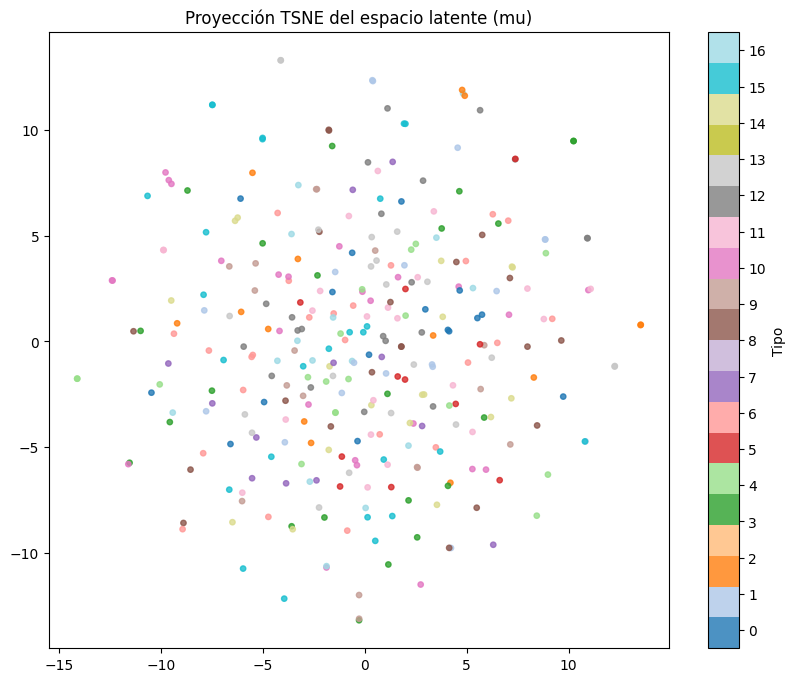

In [ ]:
plot_latent_space(cvae, pokemon_loader)

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def generar_pokemons(model, tipo_nombre, n=5):
    model.eval()

    # Obtener índice del tipo
    tipo_idx = label_encoder.transform([tipo_nombre])[0]

    # Crear vector one-hot para el tipo
    tipo_onehot = torch.zeros(num_classes).to(device)
    tipo_onehot[tipo_idx] = 1
    tipo_onehot = tipo_onehot.unsqueeze(0)  # batch size 1

    # Generar n muestras
    with torch.no_grad():
        for i in range(n):
            # Sample z ~ N(0,1)
            z = torch.randn(1, latent_dim).to(device)
            # Decodificar condicionando con el tipo
            gen_img = model.decode(z, tipo_onehot)

            # Gen_img: [1,3,120,120], pasar a CPU y numpy
            img = gen_img.squeeze().cpu().permute(1, 2, 0).numpy()

            # Mostrar la imagen generada
            plt.subplot(1, n, i+1)
            plt.imshow(img)
            plt.axis('off')
        plt.suptitle(f"Pokemons generados para tipo: {tipo_nombre}")
        plt.show()

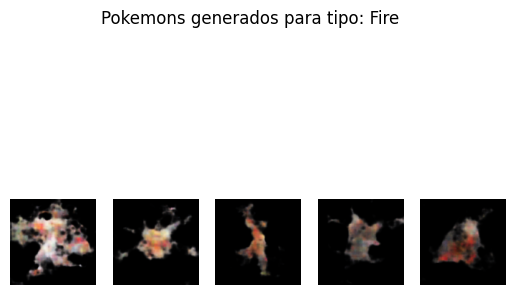

In [ ]:
generar_pokemons(cvae, "Fire", n=5)

# **Conclusiones**

Luego de explorar múltiples configuraciones para el modelo generador de Pokémon, se concluyó que la implementación más efectiva fue la que se basó en la estructura propuesta en el Práctico 5. Al adaptar dicha arquitectura a nuestro proyecto, e integrar los componentes AUG_block, DEC_block y Variational_Encoder, se logró una mejora significativa en la organización del espacio latente: se redujeron notablemente los espacios vacíos, permitiendo una representación más densa y eficiente de las variables latentes. Esto se tradujo en una mayor capacidad del modelo para captar la variabilidad de los datos y generar ejemplos más consistentes.

Asimismo, al aplicar ajustes específicos en el método de generación, las imágenes obtenidas presentaron una coherencia visual mejor en comparación con las versiones anteriores del modelo. Estas confirman la efectividad del enfoque que se usó.

En conjunto, estos resultados demuestran que la correcta elección del modelo y del entrenamiento es muy importante para obtener una generación de datos de alta calidad.

